# Datathon Crushers Source Code
## Problem Statement
We want to find optimal time to go on ski holiday
* We will be looking at prices, visitor numbers, min/max temperatures.
* We want to find the one week and one resort in 2026 where all these factors align for the ultimate holiday!


In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models import AutoARIMA
from darts.metrics import mape
from statsmodels.tsa.statespace.sarimax import SARIMAX
import gc

In [6]:
xls = pd.ExcelFile("2025 Allianz Datathon Dataset.xlsx")

In [7]:
visitDataRaw = xls.parse('Visitation Data')
visitDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year            165 non-null    int64
 1   Week            165 non-null    int64
 2   Mt. Baw Baw     165 non-null    int64
 3   Mt. Stirling    165 non-null    int64
 4   Mt. Hotham      165 non-null    int64
 5   Falls Creek     165 non-null    int64
 6   Mt. Buller      165 non-null    int64
 7   Selwyn          165 non-null    int64
 8   Thredbo         165 non-null    int64
 9   Perisher        165 non-null    int64
 10  Charlotte Pass  165 non-null    int64
dtypes: int64(11)
memory usage: 14.3 KB


### Inference
* n = 165 observations
* No missing values
* All attributes are numerical

In [6]:
visitDataRaw.describe()

Year        Week   Mt. Baw Baw  Mt. Stirling    Mt. Hotham  \
count   165.000000  165.000000    165.000000    165.000000    165.000000   
mean   2019.000000    8.000000   5373.648485    589.981818  20110.333333   
std       3.171904    4.333646   3924.269031    529.497558  12198.935589   
min    2014.000000    1.000000      0.000000      0.000000      0.000000   
25%    2016.000000    4.000000   1757.000000     98.000000   8368.000000   
50%    2019.000000    8.000000   5565.000000    480.000000  21856.000000   
75%    2022.000000   12.000000   8513.000000    962.000000  30944.000000   
max    2024.000000   15.000000  18031.000000   2097.000000  44648.000000   

        Falls Creek    Mt. Buller        Selwyn       Thredbo      Perisher  \
count    165.000000    165.000000    165.000000    165.000000    165.000000   
mean   24027.145455  29349.296970   5536.533333  30020.884848  39649.515152   
std    14176.688461  17768.711945   3383.338655  18363.819945  24258.783674   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     8741.000000  12397.000000   2180.000000  11543.000000  15236.000000   
50%    28099.000000  33328.000000   6454.000000  34676.000000  46265.000000   
75%    36692.000000  44315.000000   8530.000000  46015.000000  60788.000000   
max    49697.000000  66326.000000  12863.000000  70634.000000  93226.000000   

       Charlotte Pass  
count      165.000000  
mean      2181.812121  
std       1334.790842  
min          0.000000  
25%        842.000000  
50%       2542.000000  
75%       3344.000000  
max       5033.000000

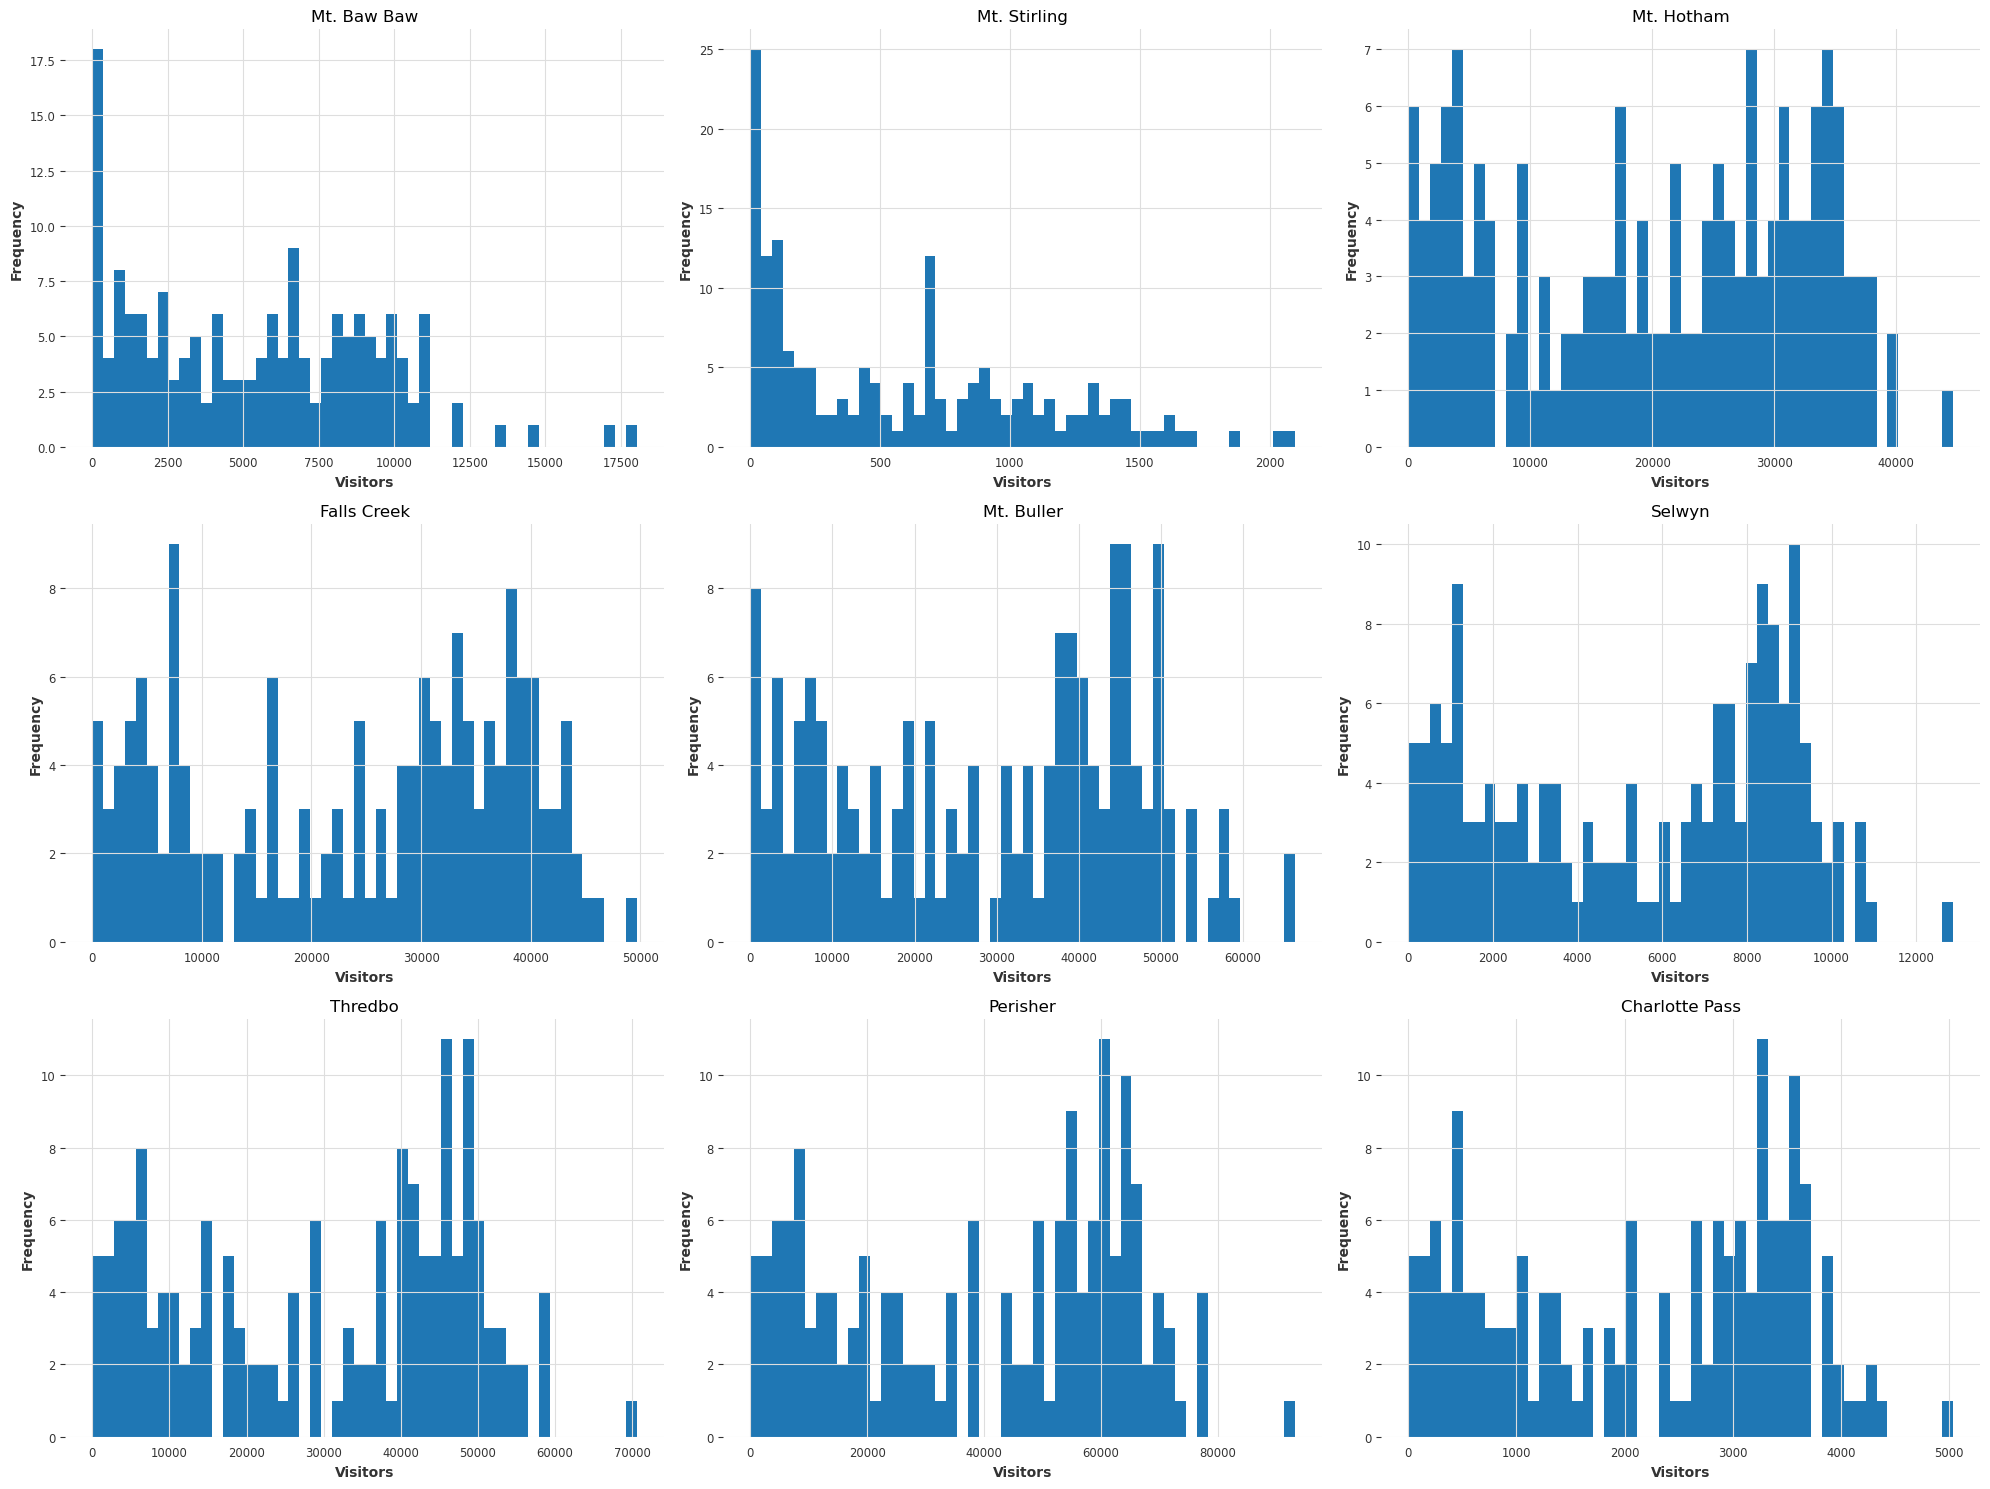

In [8]:
fig = visitDataRaw.iloc[:, 2:].hist(bins=50, figsize=(20, 15), color = '#1f77b4')

for ax_row in fig:
    for ax in ax_row:
        ax.set_xlabel("Visitors")
        ax.set_ylabel("Frequency")
        
plt.tight_layout()
plt.savefig("overall_analysis.png", dpi=300)

plt.show()

### Inference
* All units are identical
* 0 indicators days in which the resort was closed
* Mt. Baw Baw and Mt. Stirling are right skewed
* Most of the resorts exhibit double peaks
    * There are 'peak' periods and 'non-peak' periods

## Cleaning Data Classes

In [9]:
class cleanVisit:
    def __init__(self, data):
        self.data = data
        
    def fromWeeksToDates(self):
        years = self.data['Year'].astype(int)
        weeks = self.data['Week'].astype(int)
        june1 = pd.to_datetime(dict(year=years, month=6, day=1))
        first_mon = june1 + pd.to_timedelta((7 - june1.dt.weekday) % 7, unit='D')
        self.data['Dates'] = first_mon + pd.to_timedelta(weeks - 1, unit='W')
        self.data = self.data.drop(columns=['Year', 'Week'])
        self.data = self.data[['Dates'] + [c for c in self.data.columns if c != 'Dates']]
        self.data = self.data.sort_values(by='Dates')

    def getResort(self, i):
        self.data = self.data.iloc[:, [0, i]]

class climateClean:
    def __init__(self, data):
        self.data = data

    def fromYMDtoDates(self):
        self.data['Dates'] = self.data.apply(lambda row: datetime(int(row['Year']), int(row['Month']), int(row['Day'])), axis=1)
        self.data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
        self.data = self.data[['Dates'] + [col for col in self.data.columns if col != 'Dates']]

    def filterStation(self, station):
        self.data = self.data[self.data['Bureau of Meteorology station number'] == station]

    def getAve(self):
        self.data['WeekStart'] = self.data['Dates'] - pd.to_timedelta(self.data['Dates'].dt.weekday, unit='d')
        
        weekly = self.data.groupby('WeekStart').agg({
            'Maximum temperature (Degree C)': 'mean',
            'Minimum temperature (Degree C)': 'mean',
            'Rainfall amount (millimetres)': 'sum'
        }).rename(columns={
            'Maximum temperature (Degree C)': 'MaxTemp',
            'Minimum temperature (Degree C)': 'MinTemp',
            'Rainfall amount (millimetres)': 'Rain'
        }).reset_index()
        
        self.data = self.data.merge(weekly, on='WeekStart', how='left')
        
        self.data['Maximum temperature (Degree C)'] = self.data['MaxTemp']
        self.data['Minimum temperature (Degree C)'] = self.data['MinTemp']
        self.data['Rainfall amount (millimetres)'] = self.data['Rain']

        self.data.drop(columns=['WeekStart', 'MaxTemp', 'MinTemp', 'Rain'], inplace=True)


    def keepRelevantData(self, data):
        self.data = self.data[self.data['Dates'].isin(data['Dates'])]

    def combineData(self, data):
        self.data = pd.DataFrame(np.hstack([data, self.data.drop(['Dates'], axis = 1)]))

In [10]:
visitDataObj = cleanVisit(visitDataRaw)
visitDataObj.fromWeeksToDates()
visitDataObj.data

Dates  Mt. Baw Baw  Mt. Stirling  Mt. Hotham  Falls Creek  \
0   2014-06-02          555            60        3483         2790   
1   2014-06-09          804            42        1253         1425   
2   2014-06-16          993            30        2992         2101   
3   2014-06-23         2976           165        9680         9544   
4   2014-06-30        11112           645       29628        26211   
..         ...          ...           ...         ...          ...   
160 2024-08-12         5977          1416       24260        38541   
161 2024-08-19         3597           701       19289        42101   
162 2024-08-26         1500           213       14487        25252   
163 2024-09-02            0             0        2700        17137   
164 2024-09-09            0             0           0        12950   

     Mt. Buller  Selwyn  Thredbo  Perisher  Charlotte Pass  
0          8296    1041     5535      7370             408  
1          1987     383     2090      2751             151  
2          2413     597     3216      4255             230  
3         18831    2877    15497     20265            1134  
4         49217    8588    46546     61339            3403  
..          ...     ...      ...       ...             ...  
160       43387    6859    37608     49136            2667  
161       36668    5969    33208     43382            2392  
162       15415    3351    18120     23908            1323  
163           0    1177     6270      8244             454  
164           0     745     4103      5336             294  

[165 rows x 10 columns]

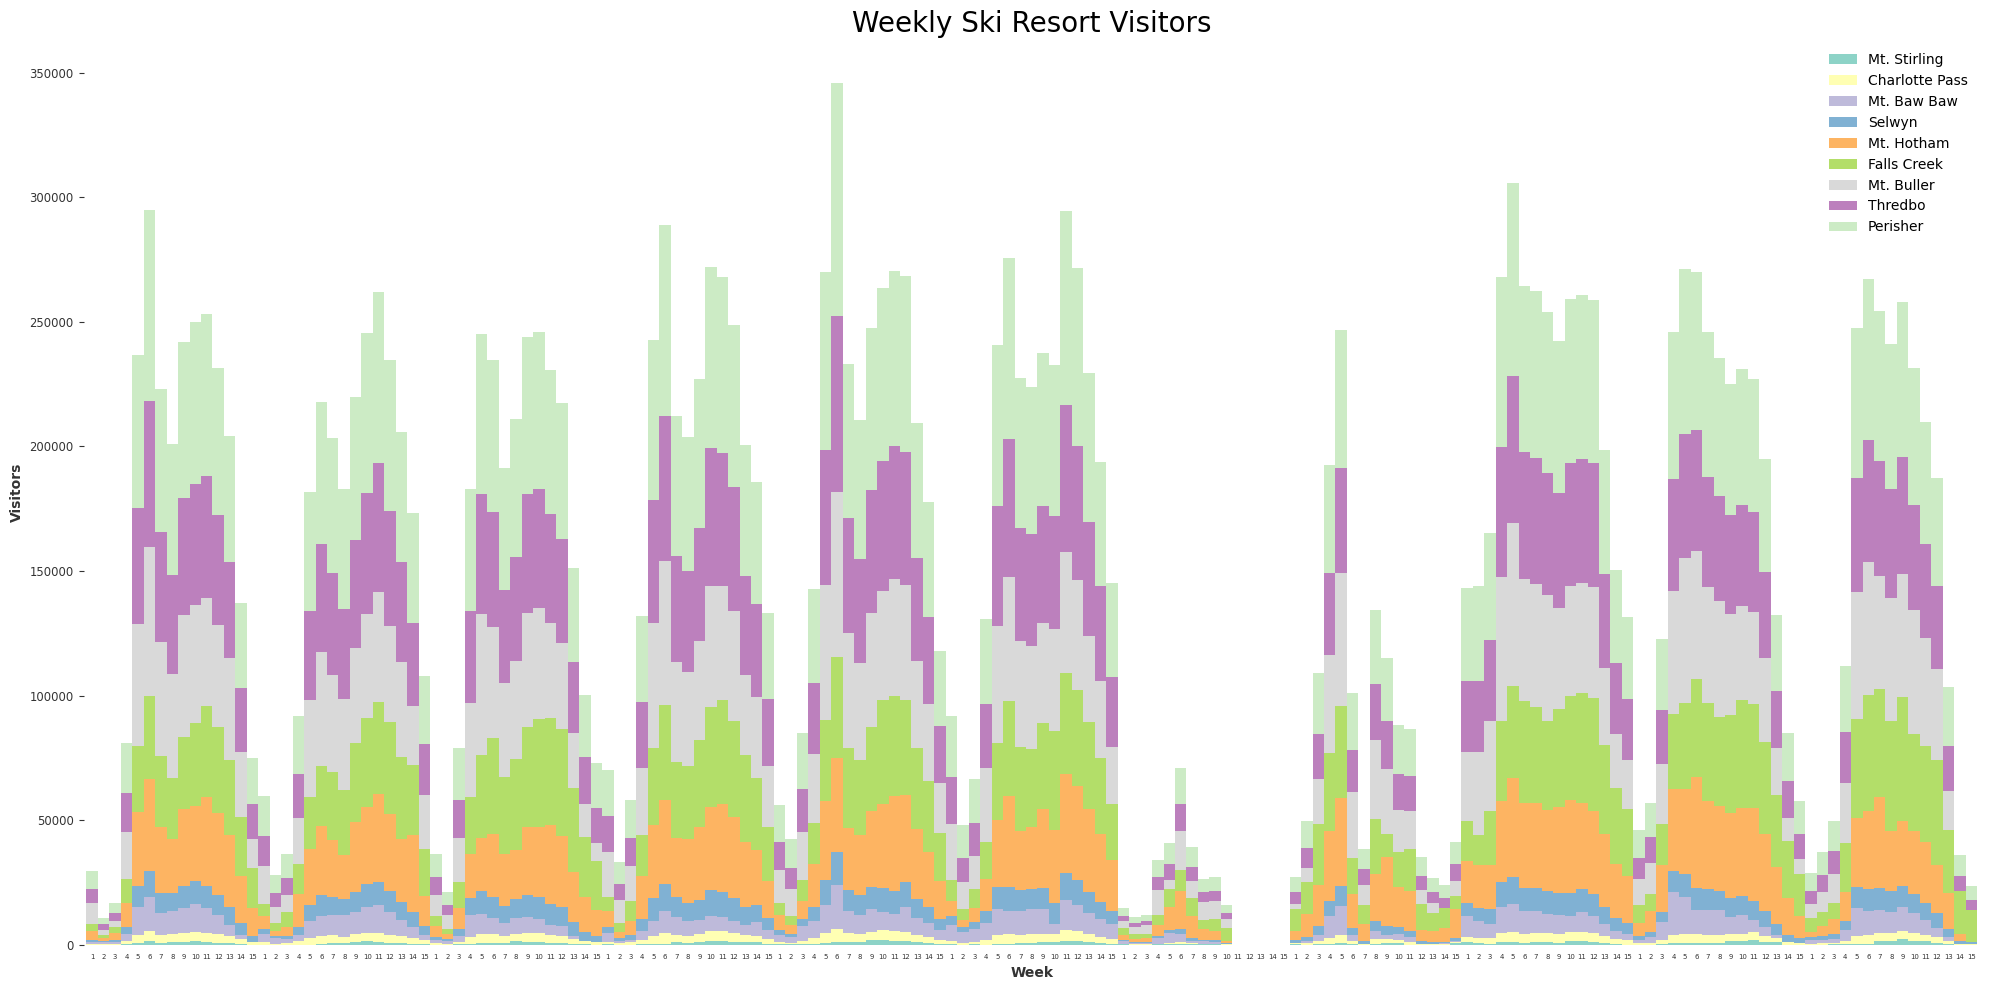

In [11]:
df_area = visitDataObj.data.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=5)
plt.tight_layout()
plt.grid(False)
plt.savefig("weekly_visitors.png", dpi=300)
plt.show()

### Inference (To do)
* Week 2 has the lowest amount of people
* We observe the double peaks during season with middle of the peaks having less people
* The trough of the peaks is moving right as time progresses
* 2020 data and 2021 are invalid beacuse of COVID policy and pandemic restrictions
    * Along with this, 2022 data cannot be used as the 1st, 2nd, 3rd weeks present huge outliers when we do SARIMA modelling. Since SARIMA takes into account only 11 data points for each week of the 15 week 'season' (Years), each point has higher leverage and outliers should be discarded.
    * The 2022 data having abnormally high numbers for first few weeks is likely a result of temporary increases in visitors as restrictions are loosened. However, this being temporary we shouldn't use this to predict future data where we do not expect something as drastic as COVID to happen again.

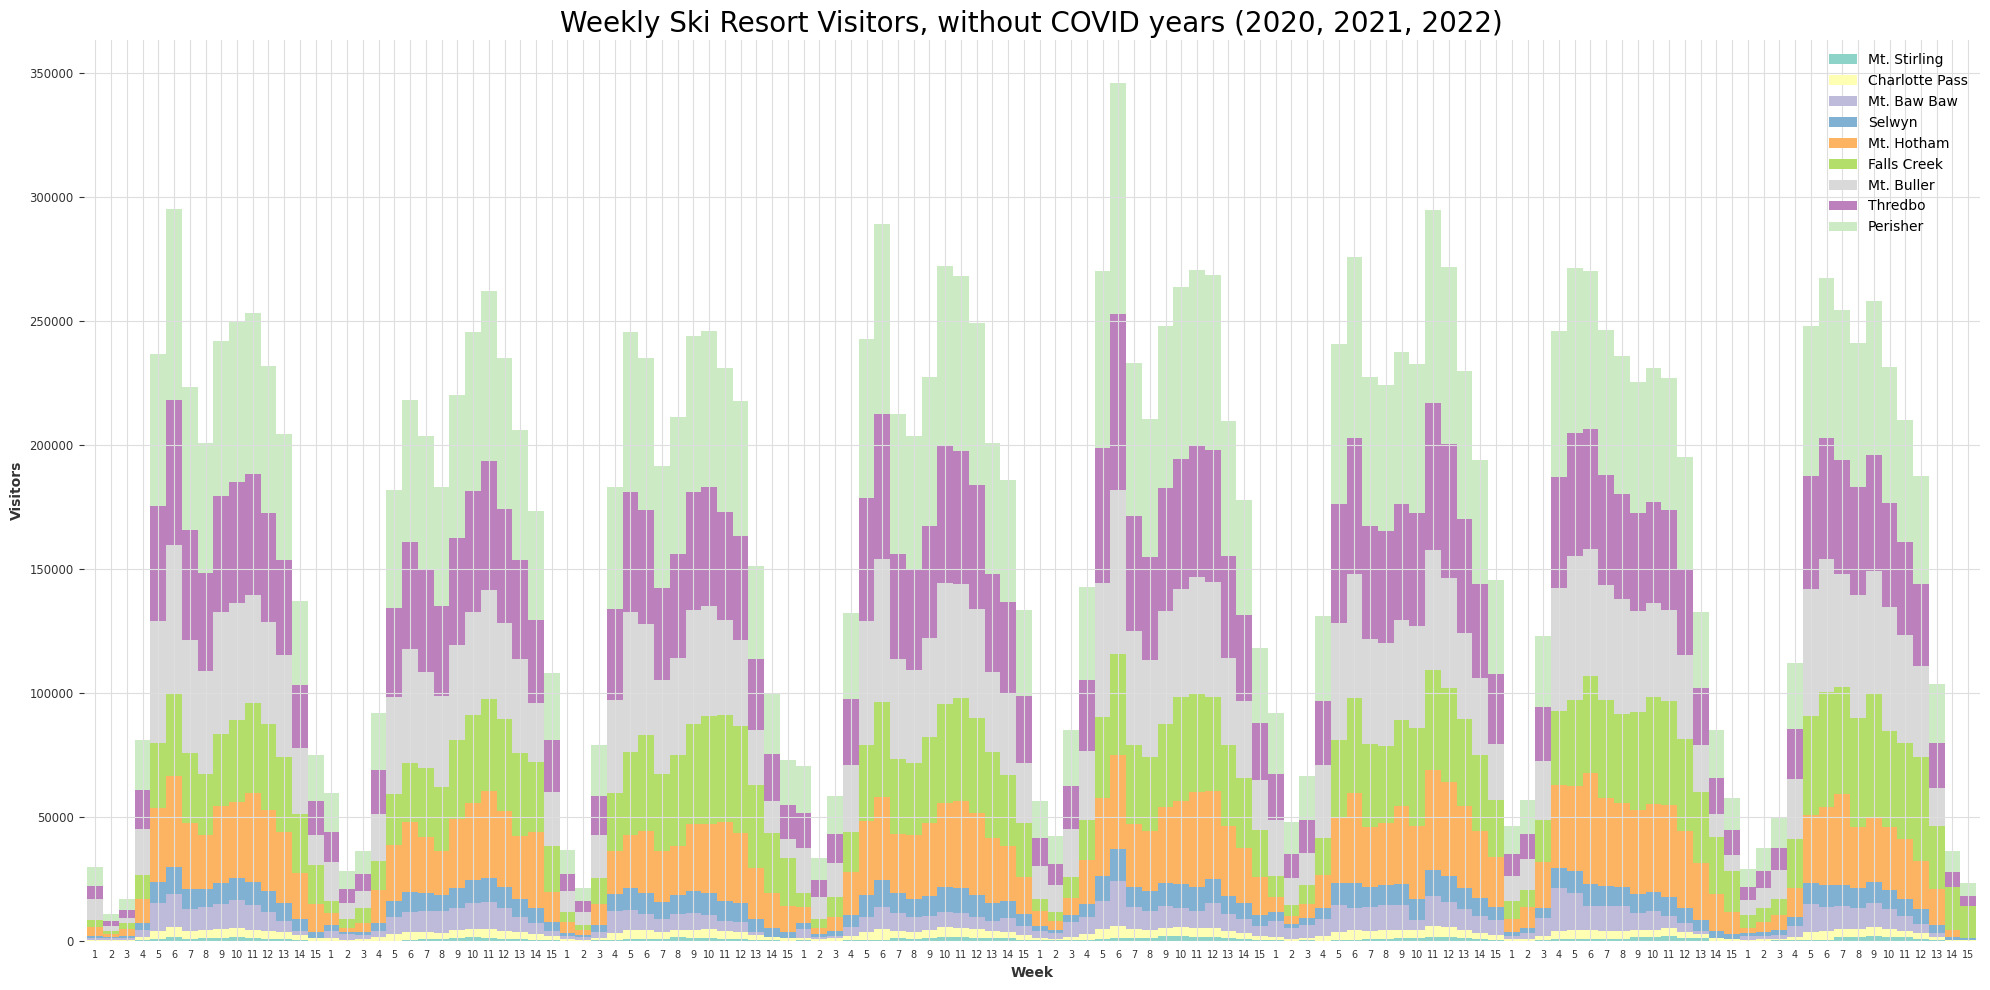

In [14]:
visitData_sliced = visitDataObj.data[~visitDataObj.data['Dates'].dt.year.isin([2020, 2021, 2022])]

df_area = visitData_sliced.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors, without COVID years (2020, 2021, 2022)", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig("weekly_visitors_AFTERCLEAN.png", dpi=300)

plt.show()

### Inference
* Our cleaned dataset. Notice the seasonality of the data. This means that SARIMA, exponential smoothing and deep learning models may be a good fit for the data as they account for seasonality.

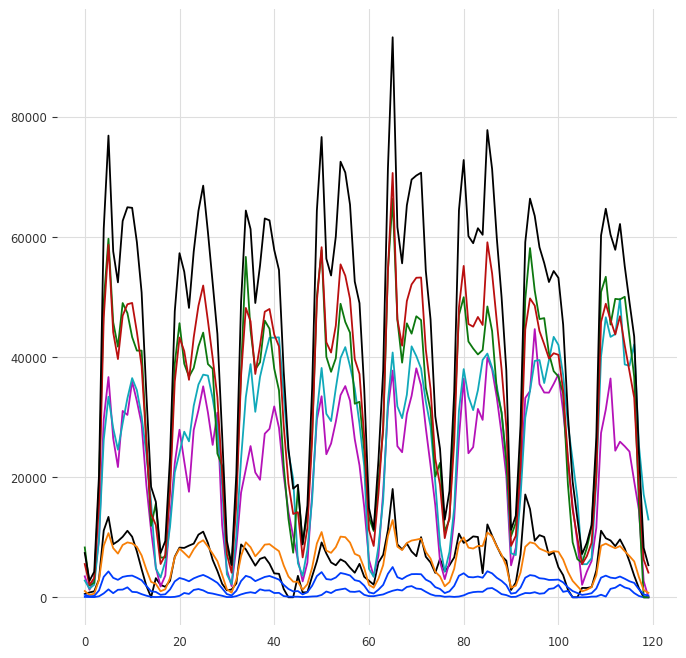

In [16]:
cleaned_visit = visitData_sliced.reset_index(drop=True).drop(['Dates'], axis = 1)
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(cleaned_visit);

### Inference
* Seasonality is further evidenced here. We can also see the bi-peaks in every season.
* The data may be able to be autoregressed as it seems every week looks to be correlated to the same week the seasons before.

# Visitation Model Selection

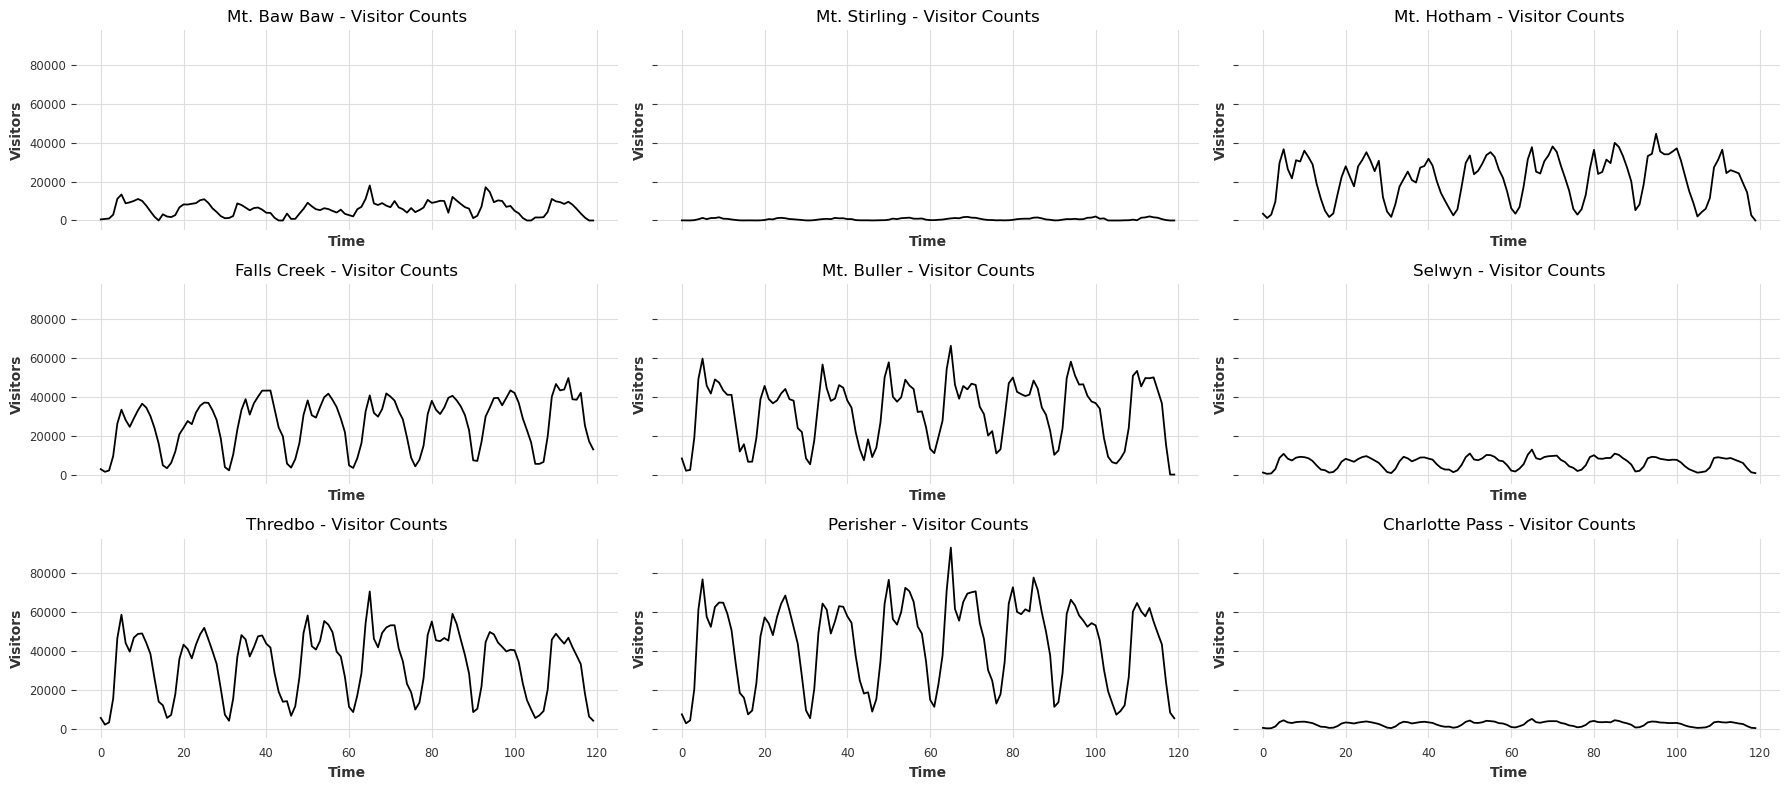

In [19]:
series_list = []
resort_columns = cleaned_visit.columns[0:9]

fig, axes = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, col in enumerate(resort_columns):
    series = cleaned_visit[col].to_numpy()
    series_list.append(series)

    axes[i].plot(series)
    axes[i].set_title(f"{col} - Visitor Counts")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Visitors")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

series_array = np.array(series_list)

### Inferences
* Apart from Mt. Baw Baw, the data shows seasonality meaning that exponential smoothing and SARIMA can be applied.

In [21]:
num_series, num_timesteps = series_array.shape

time_index = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='W-MON')
ts_array = []

for i in range(num_series):
    df = pd.DataFrame({
        'Time': time_index,
        'Value': series_array[i]
    })

    ts = TimeSeries.from_dataframe(df, time_col='Time', value_cols='Value', fill_missing_dates=False)
    ts_array.append(ts)

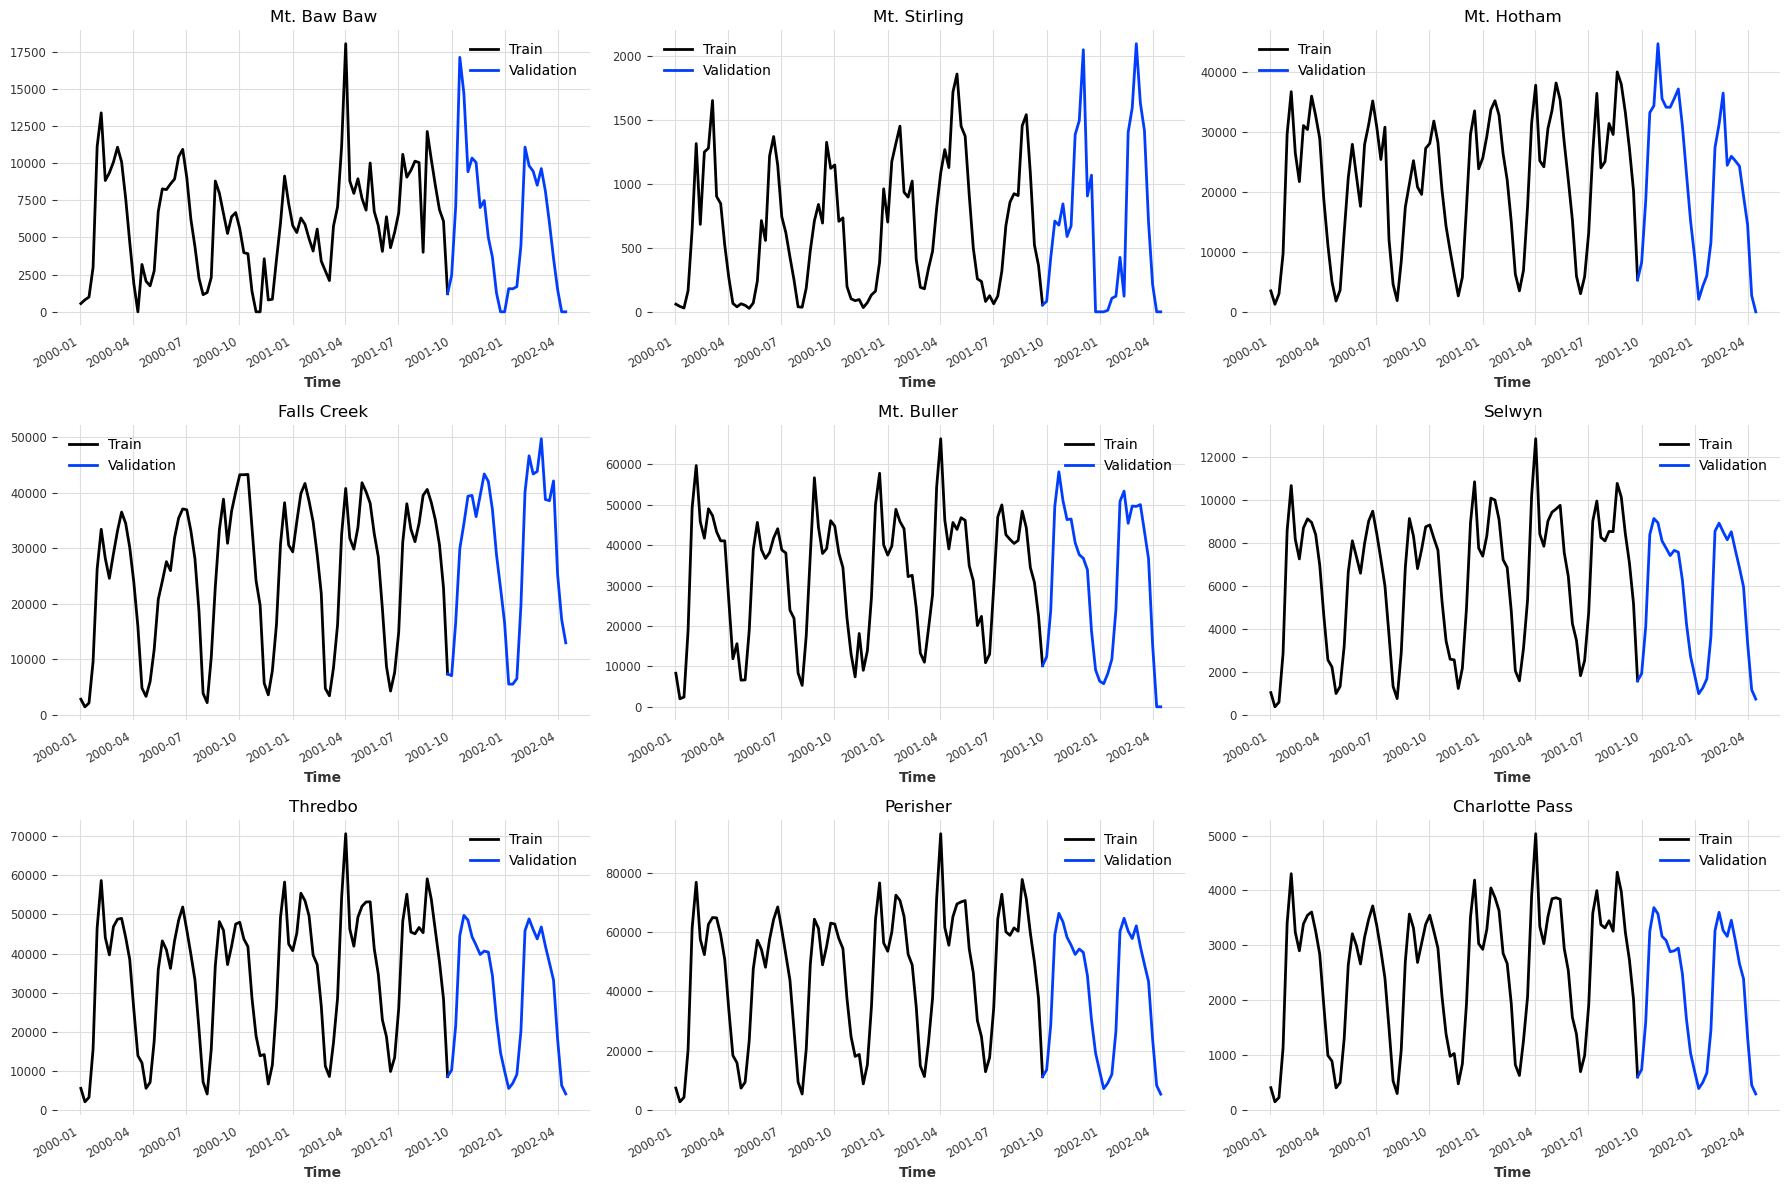

In [22]:
col_names = visitDataObj.data.columns[1:10]

train_array = []
val_array = []

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array[:9], col_names)):
    train = ts[:-29]
    val = ts[-30:]

    train_array.append(train)
    val_array.append(val)

    ax = axs[i]
    train.plot(ax=ax, label='Train')
    val.plot(ax=ax, label='Validation')
    ax.set_title(name)
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

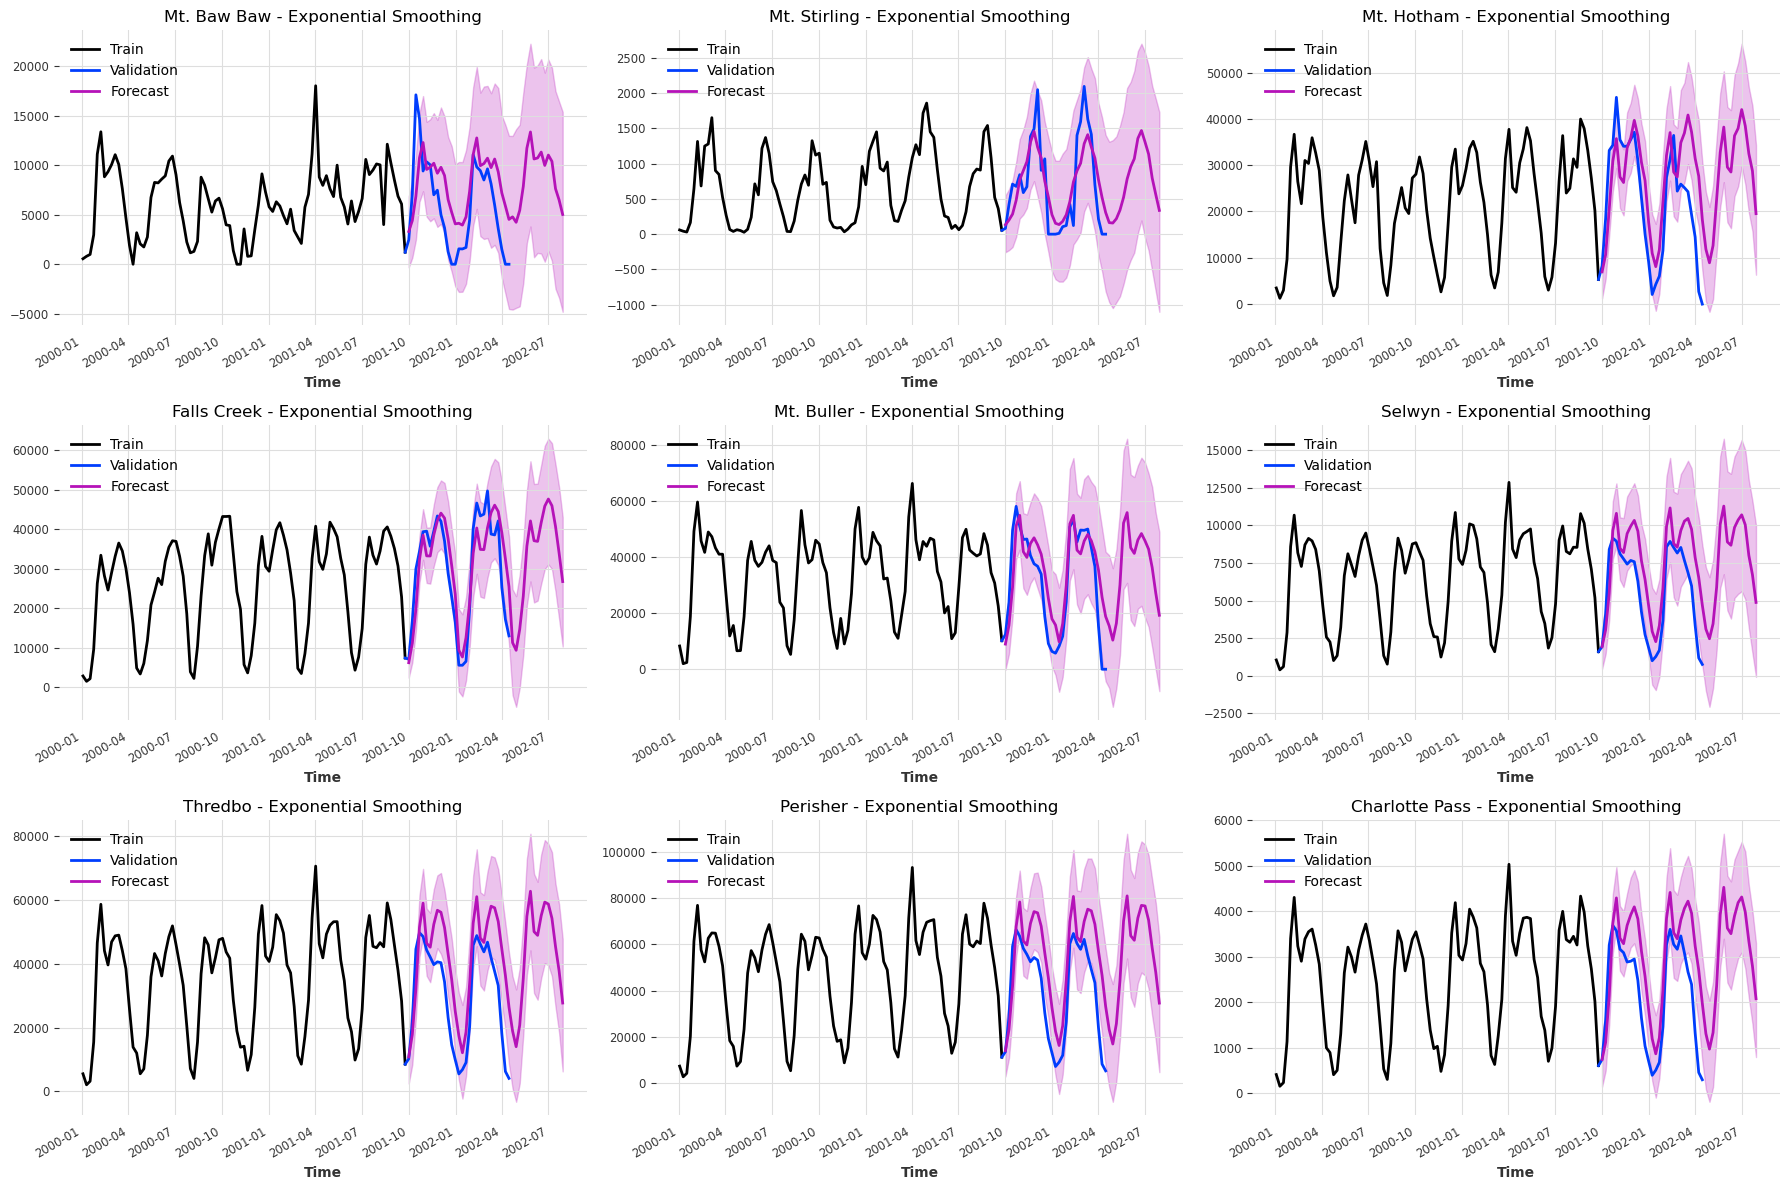

In [23]:
col_names = visitDataObj.data.columns[1:10]

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model = ExponentialSmoothing(seasonal_periods=15)
    model.fit(train)
    prediction = model.predict(len(val) + 14, num_samples=1000)

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    prediction.plot(ax=ax, label="Forecast", low_quantile=0.05, high_quantile=0.95)

    ax.set_title(f"{name} - Exponential Smoothing")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

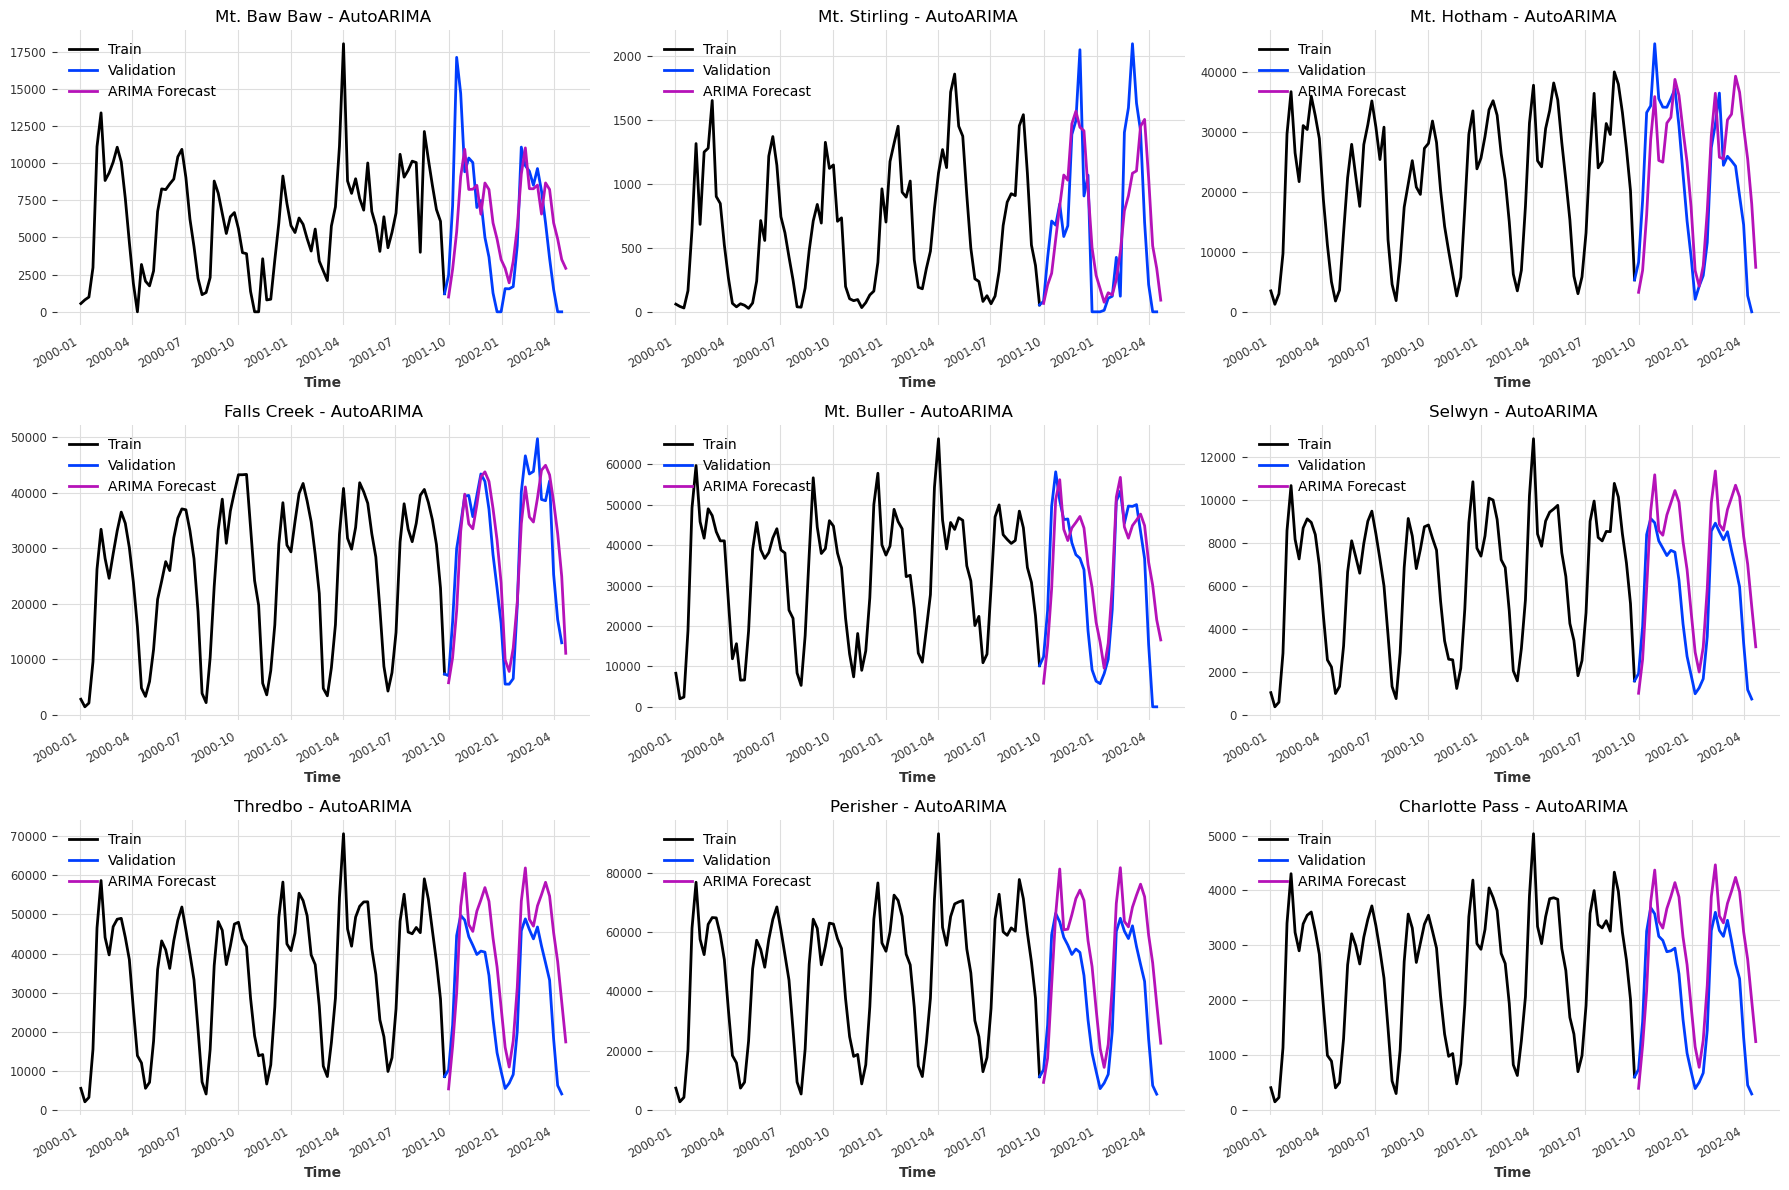

In [24]:
col_names = visitDataObj.data.columns[1:10]  # Names for the plots

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model_arima = AutoARIMA(season_length=15)
    model_arima.fit(train)
    forecast_arima = model_arima.predict(len(val))

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    forecast_arima.plot(ax=ax, label="ARIMA Forecast")

    ax.set_title(f"{name} - AutoARIMA")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

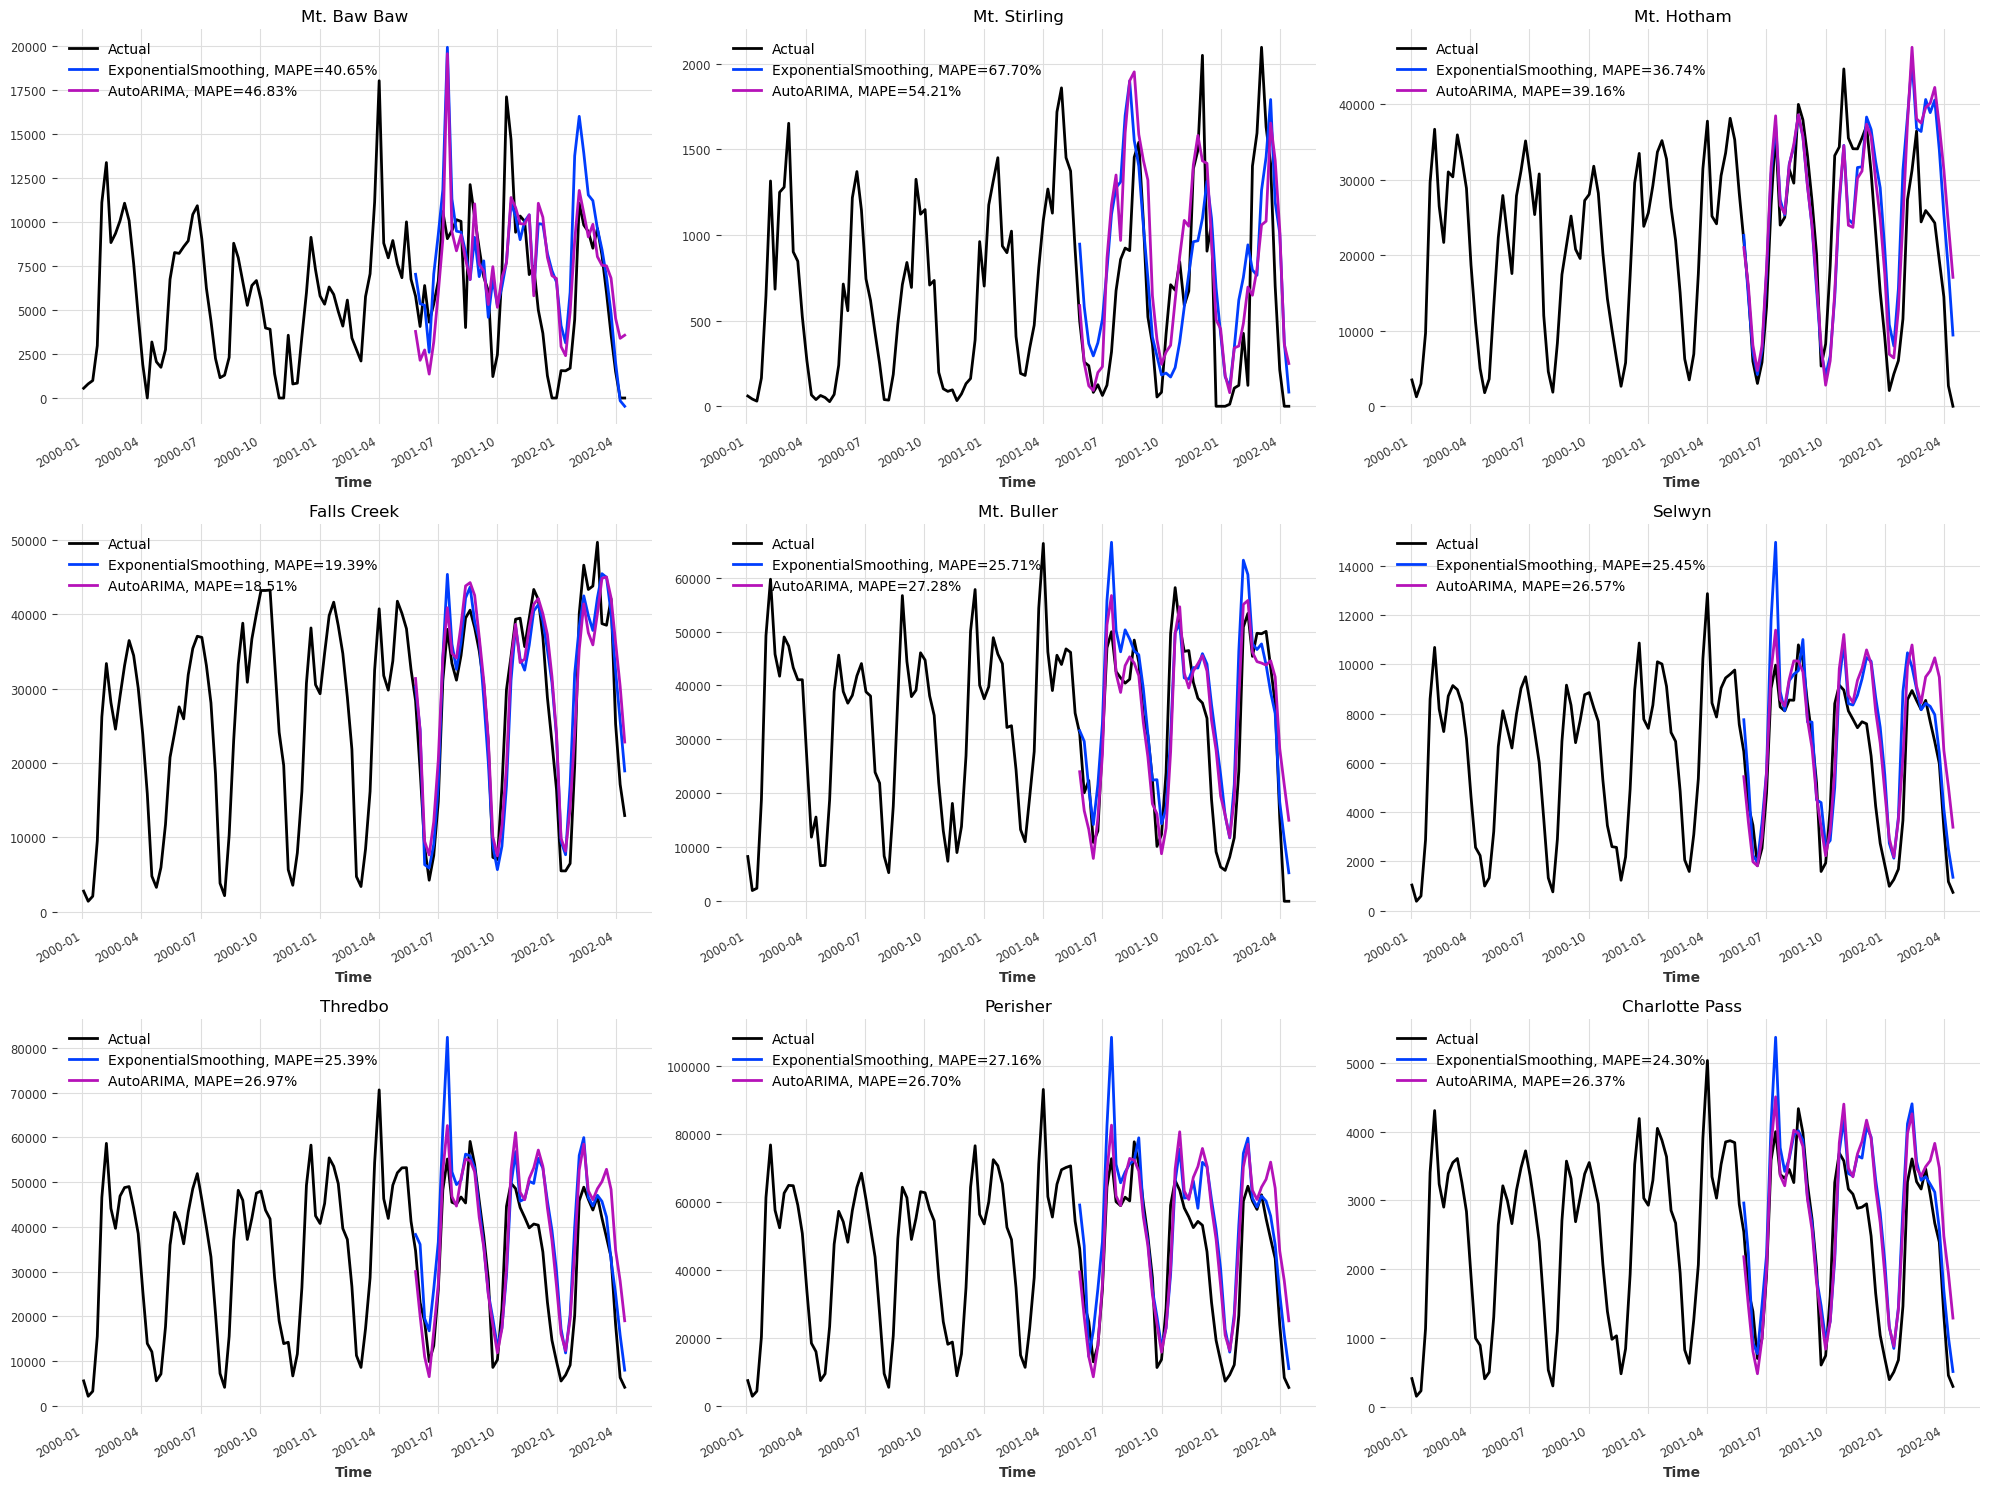

In [25]:
col_names = visitDataObj.data.columns[1:10]

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array, col_names)):
    models = [
        ExponentialSmoothing(seasonal_periods=15),
        AutoARIMA(season_length=15)
    ]

    backtests = [
        model.historical_forecasts(
            ts, start=0.5, forecast_horizon=15,
            stride=1, retrain=True, verbose=False
        ) for model in models
    ]

    ax = axs[i]
    ts.plot(ax=ax, label='Actual', lw=2)

    for model, bt in zip(models, backtests):
        err = mape(bt, ts.drop_before(bt.start_time()))
        bt.plot(ax=ax, label=f'{model.__class__.__name__}, MAPE={err:.2f}%')

    ax.set_title(f"{name}")
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Inferences
* From our backtests we see that different models produced smaller MAPEs on different resort datasets. To avoid overfitting, we concluded that exponential smoothing best fit our purposes as it has the lowest overall MAPE.
* Trough of the data consistently occurs at around week 8.

# Climate Data Model Selection

## Maximum Temperature

In [28]:
climateDataRaw = xls.parse('Climate Data')
climateData_maxtemp = climateDataRaw[[
    'Bureau of Meteorology station number',
    'Year',
    'Month',
    'Day',
    'Maximum temperature (Degree C)'
]]
climateData_maxtemp

Bureau of Meteorology station number  Year  Month  Day  \
0                                     71075  2010      1    1   
1                                     71075  2010      1    2   
2                                     71075  2010      1    3   
3                                     71075  2010      1    4   
4                                     71075  2010      1    5   
...                                     ...   ...    ...  ...   
39808                                 72161  2025      7   24   
39809                                 72161  2025      7   25   
39810                                 72161  2025      7   26   
39811                                 72161  2025      7   27   
39812                                 72161  2025      7   28   

       Maximum temperature (Degree C)  
0                                 NaN  
1                                 NaN  
2                                 NaN  
3                                 NaN  
4                                 NaN  
...                               ...  
39808                             3.0  
39809                             6.0  
39810                             2.7  
39811                             2.5  
39812                             2.2  

[39813 rows x 5 columns]

In [29]:
station_ids = [71032, 71075, 72161, 83024, 83084, 83085, 85291]
climate_datasets = []

for station_id in station_ids:
    obj = climateClean(climateData_maxtemp.copy())
    obj.fromYMDtoDates()
    obj.filterStation(station_id)
    climate_datasets.append(obj.data)

climate_datasets = [df.fillna(method='ffill') for df in climate_datasets]

exog_cols = [
    'Maximum temperature (Degree C)',
]

ts_array = []

for i, df in enumerate(climate_datasets):
    df = df.copy()

    # ensure datetime & sorted
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.sort_values('Dates')

    # set daily frequency & fill gaps BEFORE making the TimeSeries (robust for any Darts version)
    df = df.set_index('Dates').asfreq('D')

    # forward-fill then back-fill to remove NaNs (pick the policy you prefer)
    df[exog_cols] = df[exog_cols].ffill().bfill()

    # build multivariate TimeSeries (3 components: max/min temp, rain)
    ts = TimeSeries.from_dataframe(
        df.reset_index(),
        time_col='Dates',
        value_cols=exog_cols,
        fill_missing_dates=False  # already regular at 'D'
    )
    ts_array.append(ts)

len(ts_array), ts_array[0].components

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_12256/939280317.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  climate_datasets = [df.fillna(method='ffill') for df in climate_datasets]


(7, Index(['Maximum temperature (Degree C)'], dtype='object'))

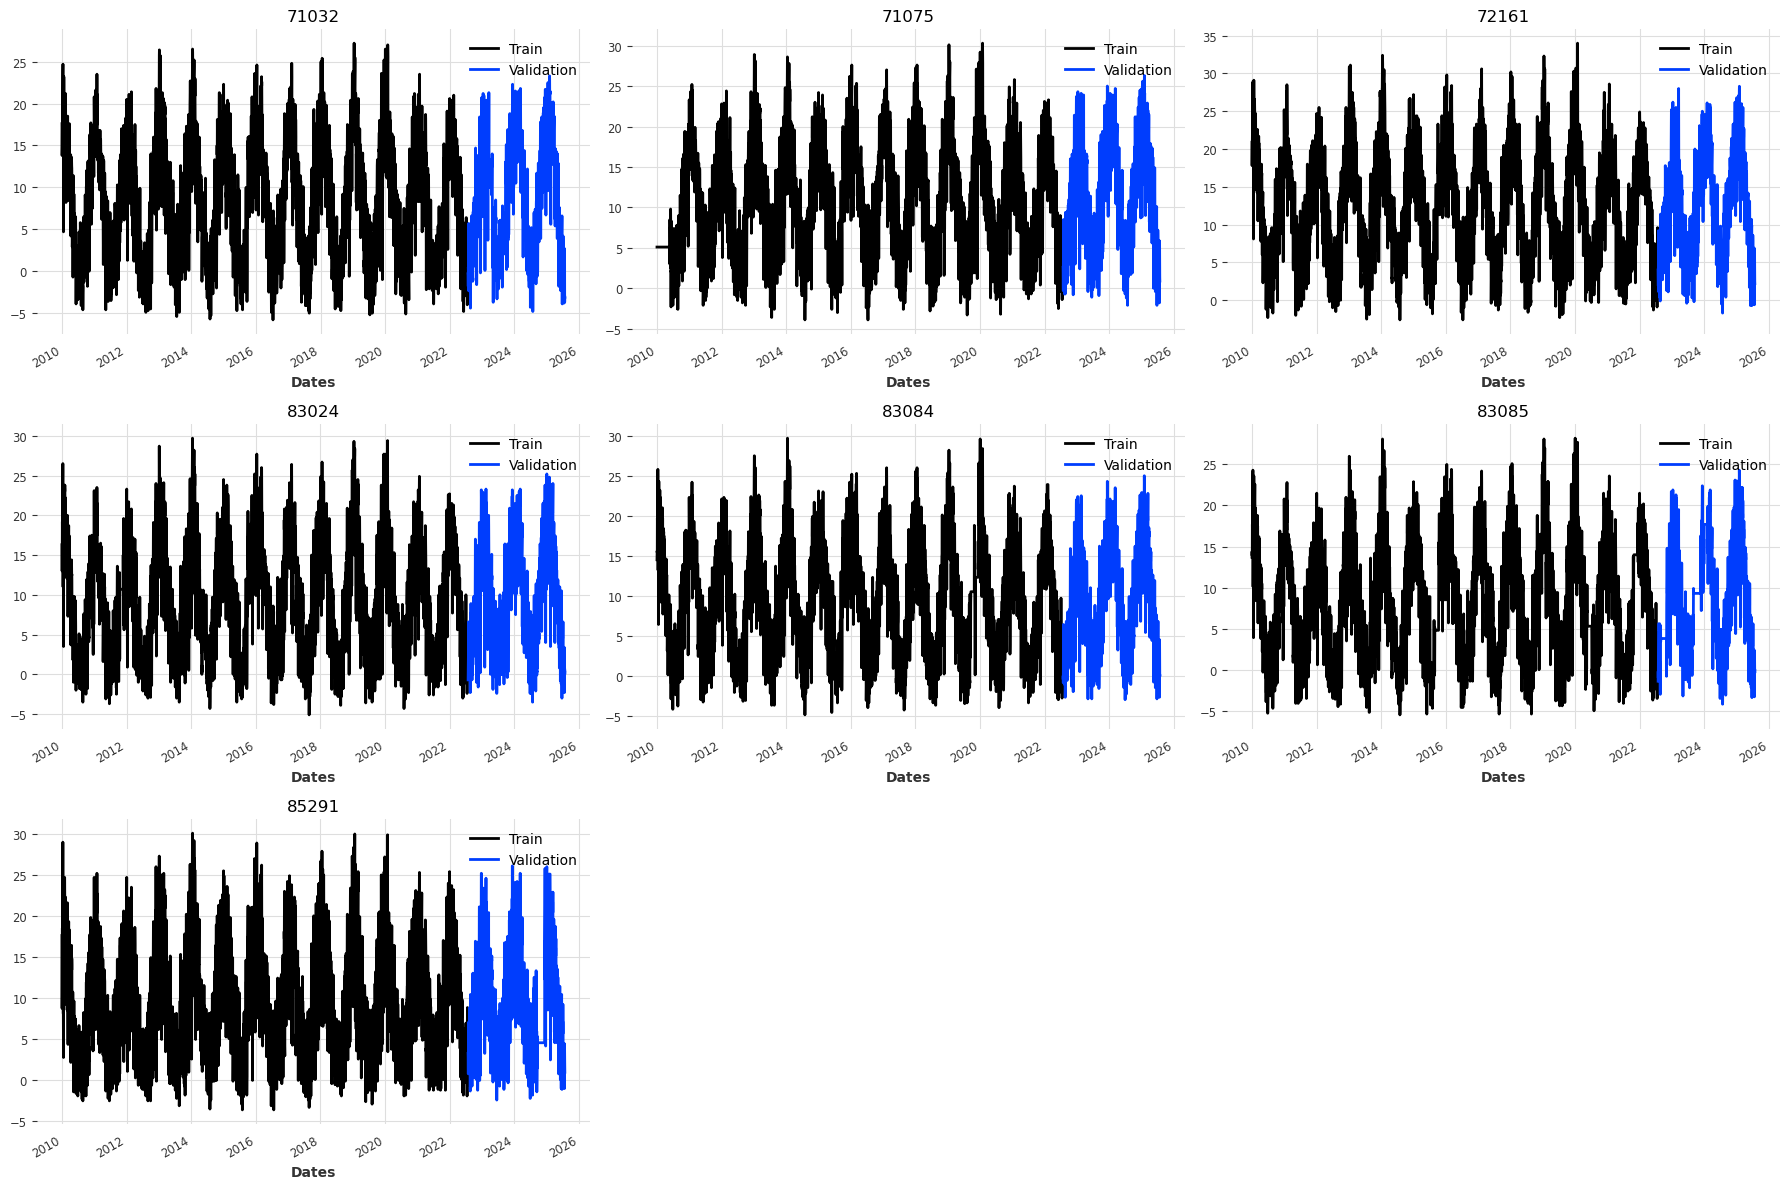

In [59]:
col_names = [71032, 71075, 72161, 83024, 83084, 83085, 85291]

train_array = []
val_array = []

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array[:9], col_names)):
    train = ts[:-(365 * 3 -1)]
    val = ts[-365 * 3:]

    train_array.append(train)
    val_array.append(val)

    ax = axs[i]
    train.plot(ax=ax, label='Train')
    val.plot(ax=ax, label='Validation')
    ax.set_title(name)
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model_arima = AutoARIMA(season_length=365)
    model_arima.fit(train)
    forecast_arima = model_arima.predict(len(val))

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    forecast_arima.plot(ax=ax, label="ARIMA Forecast")

    ax.set_title(f"{name} - AutoARIMA")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed

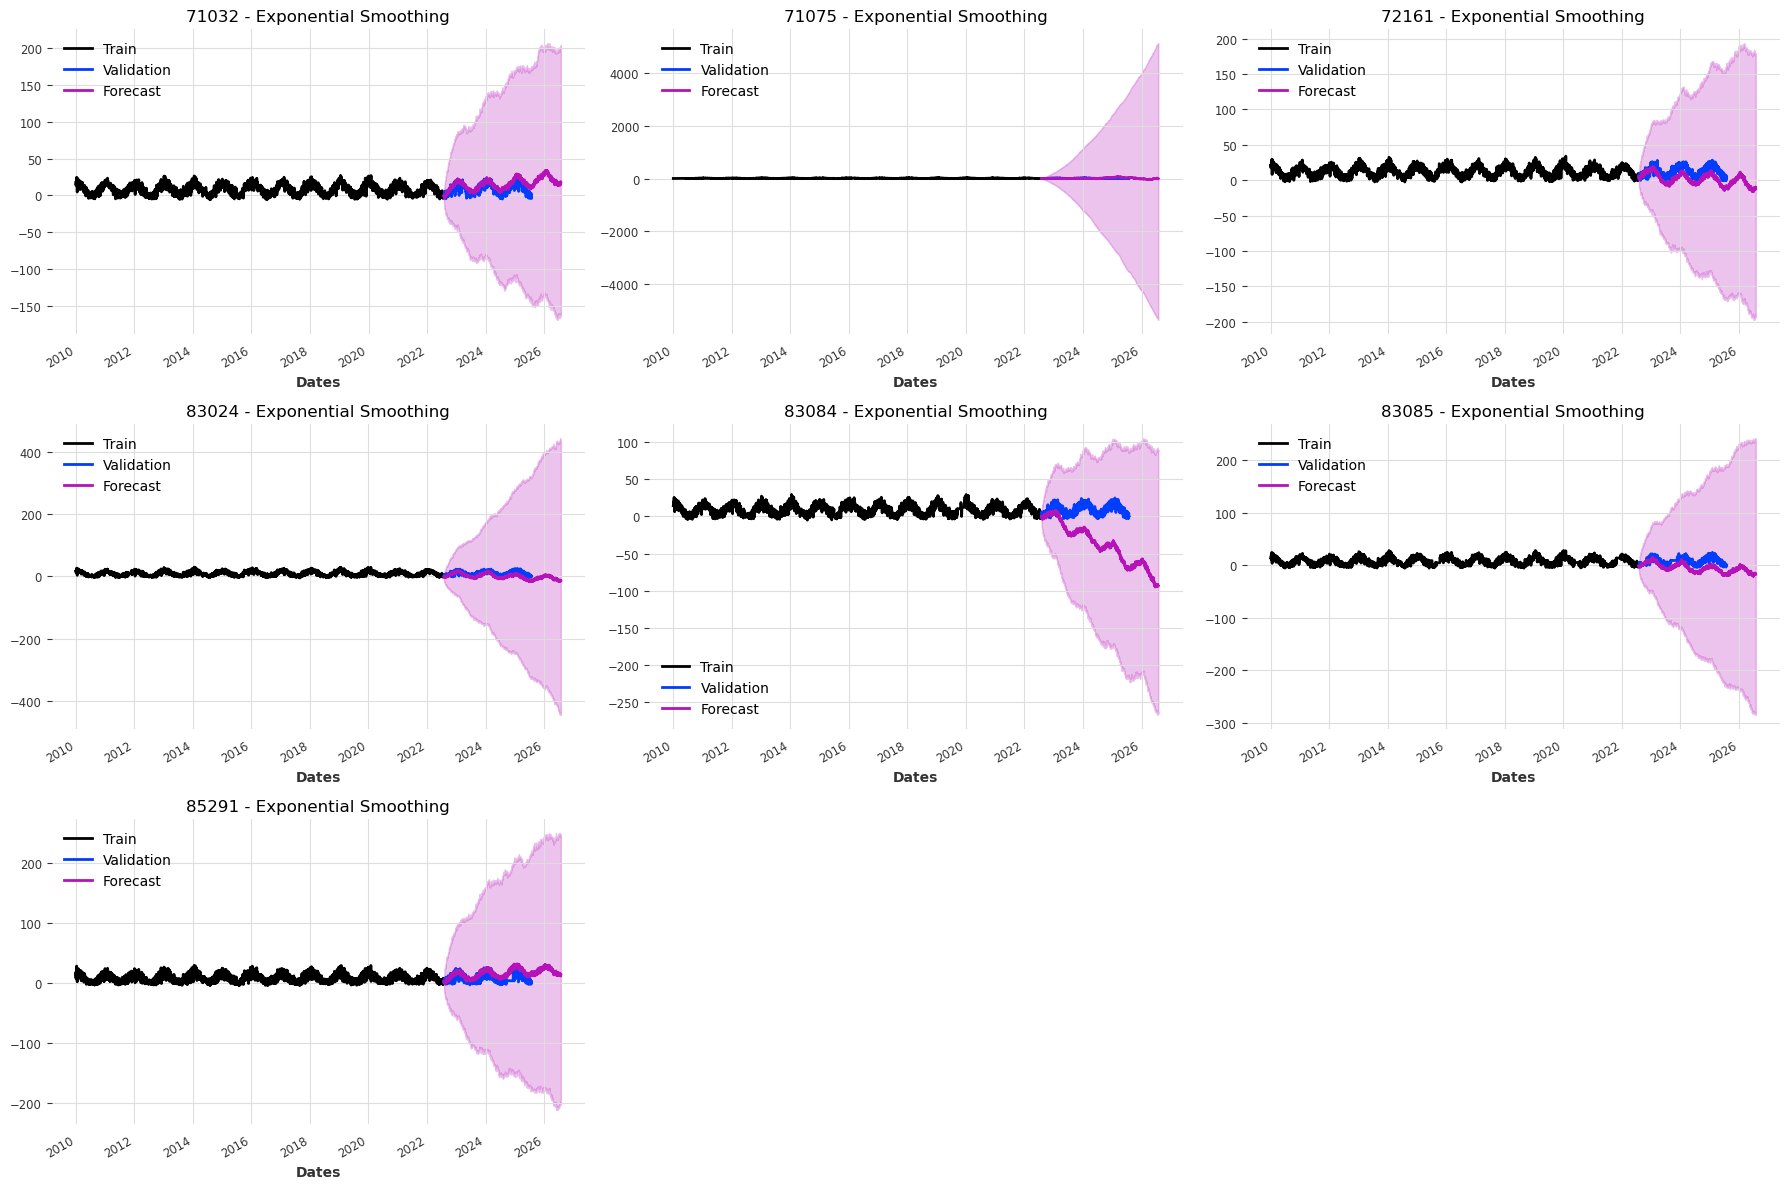

In [77]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model = ExponentialSmoothing(seasonal_periods=365)
    model.fit(train)
    prediction = model.predict(len(val) + 365, num_samples=1000)

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    prediction.plot(ax=ax, label="Forecast", low_quantile=0.05, high_quantile=0.95)

    ax.set_title(f"{name} - Exponential Smoothing")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Price Data

In [14]:
import os, re, time, json, math
from datetime import date, timedelta
from urllib.parse import urlencode

import httpx
import pandas as pd
from parsel import Selector


## Configurations

In [ ]:
HEADERS = {
    "user-agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/122.0 Safari/537.36"
    ),
    "accept-language": "en-US,en;q=0.9",
}

BASE = "https://www.booking.com/searchresults.html"


RESORTS = {
    "Thredbo": "-1604552",
    "Perisher": "-1603659",
    "Falls Creek": "-1562251",
    "Mt Buller": "-1572657",
    "Mt Hotham": "-1569309",
    "Mt Baw Baw": "-1590934",
    "Charlotte Pass": "-1565878",
    "Selwyn": "-1556428",        
    "Mt Stirling": "-1572624",
}

# Travel party / formatting (used for every search)
DEFAULT_ADULTS = 2
DEFAULT_ROOMS = 1
DEFAULT_CHILDREN = 0
DEFAULT_LANG = "en-us"
DEFAULT_CURRENCY = "AUD"

# Date windows to scrape (e.g., each Monday start, 5-night stay)
SEASON_START = date(2026, 1, 1)   # first check-in (YYYY, M, D)
SEASON_END   = date(2026, 12, 31)  # last check-in
STAY_NIGHTS  = 6                  # length of stay per query
WEEK_STEP    = 7                  # days between check-ins

# Scraper politeness + pagination
MAX_PAGES_PER_QUERY = 3     # Booking paginates by ~25 results per page
REQUEST_DELAY_SEC   = 1.5   # delay between pages
PROXIES = None

## URL Builder

In [16]:
# URL builder (keeps queries consistent)
def build_url(
    place: str,
    dest_id: str,
    checkin: str,
    checkout: str,
    adults: int = DEFAULT_ADULTS,
    rooms: int = DEFAULT_ROOMS,
    children: int = DEFAULT_CHILDREN,
    currency: str = DEFAULT_CURRENCY,
    lang: str = DEFAULT_LANG,
    offset: int = 0,   # 0, 25, 50...
):
    params = {
        "ss": place,
        "dest_id": dest_id,
        "dest_type": "city",
        "checkin": checkin,
        "checkout": checkout,
        "group_adults": adults,
        "no_rooms": rooms,
        "group_children": children,
        "lang": lang,
        "selected_currency": currency,
        "offset": offset,
        "sb": 1,  # search trigger flag
    }
    return f"{BASE}?{urlencode(params)}"



## HTML Parser

In [17]:
# HTML parser for a search results page
def parse_search(html: str):
    sel = Selector(html)
    rows = []
    for card in sel.css("[data-testid='property-card']"):
        name = card.css("[data-testid='title']::text").get()
        link = card.css("a[data-testid='title-link']::attr(href)").get()
        address = card.css("[data-testid='address']::text").get()

        rating_text = card.css("[data-testid='review-score']::text").get()
        reviews_text = card.css("[data-testid='review-score-subtext']::text").get()

        # Price text can be nested; try a few selectors and extract plain text
        price_txt = None
        for s in [
            "[data-testid='price-and-discounted-price']",
            "[data-testid='price-and-discounted-price'] span",
            "[data-testid='price-and-discounted-price'] div",
        ]:
            node = card.css(s).get()
            if node:
                price_txt = Selector(text=node).xpath("string()").get().strip()
                break

        # crude numeric extraction; keep raw text for currency/tax notes
        price_num = None
        if price_txt:
            m = re.findall(r"\d[\d,]*", price_txt.replace(",", ""))
            if m:
                try:
                    price_num = float(m[0])
                except ValueError:
                    price_num = None

        rows.append(
            {
                "hotel_name": name,
                "hotel_url": link,
                "address": address,
                "rating_text": rating_text,
                "reviews_text": reviews_text,
                "price_text": price_txt,
                "price_total": price_num,
            }
        )

    has_next = bool(
        sel.css("a[aria-label='Next page'], button[aria-label='Next page']").get()
    )
    return rows, has_next


## Scrape window

In [18]:
# Fetch all pages for a single (place, dates) window
def scrape_window(place: str, dest_id: str, checkin: str, checkout: str,
                  max_pages: int = MAX_PAGES_PER_QUERY, delay: float = REQUEST_DELAY_SEC) -> pd.DataFrame:
    out = []
    offset = 0
    # Connect (optionally with proxies)
    with httpx.Client(headers=HEADERS, timeout=30, proxies=PROXIES) as client:
        for _ in range(max_pages):
            url = build_url(place, dest_id, checkin, checkout, offset=offset)
            r = client.get(url)
            r.raise_for_status()

            rows, has_next = parse_search(r.text)
            # add metadata to each row
            for row in rows:
                row.update(
                    {
                        "place": place,
                        "dest_id": dest_id,
                        "checkin": checkin,
                        "checkout": checkout,
                        "collected_at": pd.Timestamp.utcnow().isoformat(timespec="seconds"),
                    }
                )
            out.extend(rows)

            if not has_next:
                break

            offset += 25  # Booking typically paginates by 25 results
            time.sleep(delay)

    return pd.DataFrame(out)


## Weekly Window Function

In [19]:
# Date generator: weekly windows
def weekly_windows(start: date, end: date, nights: int = STAY_NIGHTS, step_days: int = WEEK_STEP):
    d = start
    while d <= end:
        ci = d.isoformat()
        co = (d + timedelta(days=nights)).isoformat()
        yield ci, co
        d += timedelta(days=step_days)


# Aggregate to Weekly ADR index (per place x week_start)
def weekly_index(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    tmp = df.copy()
    # nights for ADR
    tmp["nights"] = (
        pd.to_datetime(tmp["checkout"]) - pd.to_datetime(tmp["checkin"])
    ).dt.days
    tmp["adr"] = tmp.apply(
        lambda r: (r["price_total"] / r["nights"]) if (pd.notnull(r["price_total"]) and r["nights"] > 0) else None,
        axis=1,
    )
    tmp["week_start"] = pd.to_datetime(tmp["checkin"])

    weekly = (
        tmp.groupby(["place", "week_start"], as_index=False)
        .agg(
            median_adr=("adr", "median"),
            p25_adr=("adr", lambda s: s.quantile(0.25)),
            p75_adr=("adr", lambda s: s.quantile(0.75)),
            sample_size=("adr", "size"),
        )
        .sort_values(["place", "week_start"])
    )
    return weekly


## Run Scraper

In [20]:
# MAIN
if __name__ == "__main__":
    run_resorts = RESORTS

    frames = []
    for place, dest_id in run_resorts.items():
        print(f"\n=== {place} ({dest_id}) ===")
        for ci, co in weekly_windows(SEASON_START, SEASON_END, STAY_NIGHTS, WEEK_STEP):
            print(f"Scraping: {place}  {ci} → {co}")
            try:
                df = scrape_window(place, dest_id, ci, co)
                if not df.empty:
                    frames.append(df)
            except Exception as e:
                print(f"Failed {place} {ci}→{co}: {e}")
            time.sleep(0.8)  # extra politeness between queries

    # Combine all raw rows into one DataFrame
    all_rows = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    print(f"\nTotal rows collected: {len(all_rows):,}")

    if not all_rows.empty:
        # Build weekly ADR index into a DataFrame
        weekly = weekly_index(all_rows)

        print("\n✅ Scraping complete!")
        print("Raw DataFrame shape:", all_rows.shape)
        print("Weekly index DataFrame shape:", weekly.shape)

        # Now you can use `all_rows` and `weekly` directly in memory
        # Example:
        print("\nPreview of raw data:")
        print(all_rows.head())

        print("\nPreview of weekly ADR index:")
        print(weekly.head())

    else:
        print("⚠️ No data collected. Check dest_id values, dates, or slow down requests.")



=== Thredbo (-1604552) ===
Scraping: Thredbo  2026-01-01 → 2026-01-07
Scraping: Thredbo  2026-01-08 → 2026-01-14
Scraping: Thredbo  2026-01-15 → 2026-01-21
Scraping: Thredbo  2026-01-22 → 2026-01-28
Scraping: Thredbo  2026-01-29 → 2026-02-04
Scraping: Thredbo  2026-02-05 → 2026-02-11
Scraping: Thredbo  2026-02-12 → 2026-02-18
Scraping: Thredbo  2026-02-19 → 2026-02-25
Scraping: Thredbo  2026-02-26 → 2026-03-04
Scraping: Thredbo  2026-03-05 → 2026-03-11
Scraping: Thredbo  2026-03-12 → 2026-03-18
Scraping: Thredbo  2026-03-19 → 2026-03-25
Scraping: Thredbo  2026-03-26 → 2026-04-01
Scraping: Thredbo  2026-04-02 → 2026-04-08
Scraping: Thredbo  2026-04-09 → 2026-04-15
Scraping: Thredbo  2026-04-16 → 2026-04-22
Scraping: Thredbo  2026-04-23 → 2026-04-29
Scraping: Thredbo  2026-04-30 → 2026-05-06
Scraping: Thredbo  2026-05-07 → 2026-05-13
Scraping: Thredbo  2026-05-14 → 2026-05-20
Scraping: Thredbo  2026-05-21 → 2026-05-27
Scraping: Thredbo  2026-05-28 → 2026-06-03
Scraping: Thredbo  2026-06

In [23]:
print("Shape (rows, cols):", all_rows.shape)
print("\nInfo:")
print(all_rows.info())

print("\nFirst 5 rows:")
print(all_rows.head())

print("\nMissing values per column (desc):")
print(all_rows.isna().sum().sort_values(ascending=False))

print("\nDuplicate rows:", int(all_rows.duplicated().sum()))

Shape (rows, cols): (4457, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hotel_name    4457 non-null   object 
 1   hotel_url     4457 non-null   object 
 2   address       4457 non-null   object 
 3   rating_text   0 non-null      object 
 4   reviews_text  0 non-null      object 
 5   price_text    4457 non-null   object 
 6   price_total   4457 non-null   float64
 7   place         4457 non-null   object 
 8   dest_id       4457 non-null   object 
 9   checkin       4457 non-null   object 
 10  checkout      4457 non-null   object 
 11  collected_at  4457 non-null   object 
dtypes: float64(1), object(11)
memory usage: 418.0+ KB
None

First 5 rows:
              hotel_name                                          hotel_url  \
0   Thredbo Alpine Hotel  https://www.booking.com/hotel/au/thredbo-alpin...   
1            YHA Thr

In [25]:
hotel_price_df = all_rows[["checkin", "place", "hotel_name", "price_total"]]
hotel_price_df["place"].value_counts()

place
Perisher          1217
Thredbo           1083
Mt Buller         1077
Mt Baw Baw        1007
Charlotte Pass      73
Name: count, dtype: int64

## What is the distribution of prices

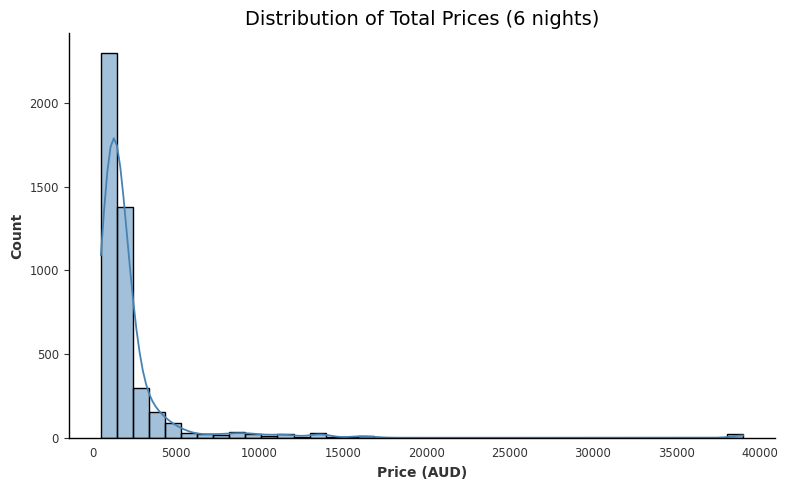

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(hotel_price_df["price_total"], bins=40, kde=True, color="steelblue")

plt.title("Distribution of Total Prices (6 nights, 2 adults)", fontsize=14)
plt.xlabel("Price (AUD)")
plt.ylabel("Count")

# Remove gridlines
plt.grid(False)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()


The distribution of total prices for a six-night stay is highly right-skewed, with the majority of hotels clustered between roughly AUD 1,000 and AUD 4,000. A sharp peak occurs around the lower end of this range, reflecting the most common mid-range accommodation options. Beyond AUD 5,000, prices become increasingly sparse, with only a small number of high-end or luxury properties pushing totals above AUD 10,000. The presence of these extreme outliers widens the overall range but does not represent the typical traveller’s cost.

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_9821/2533004862.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


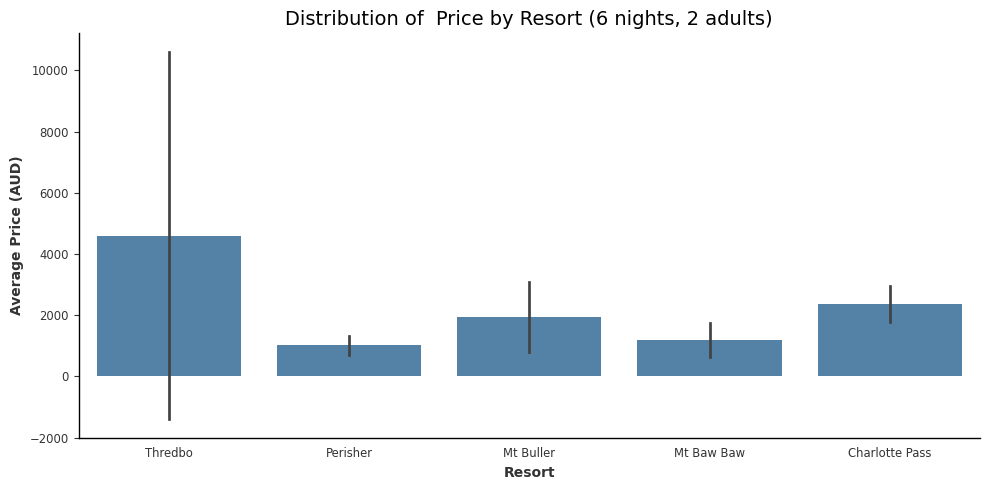

In [29]:
# --- Bar chart with error bars (mean ± std) ---
plt.figure(figsize=(10,5))
sns.barplot(
    data=hotel_price_df,
    x="place", y="price_total",
    ci="sd",  # error bars = standard deviation
    color="steelblue"
)

plt.title("Distribution of  Price by Resort (6 nights, 2 adults)", fontsize=14)
plt.xlabel("Resort")
plt.ylabel("Average Price (AUD)")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.grid(False)
plt.show()



## What is the Price over the Season

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_9821/4121856008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_price_df["checkin"] = pd.to_datetime(hotel_price_df["checkin"], errors="coerce")


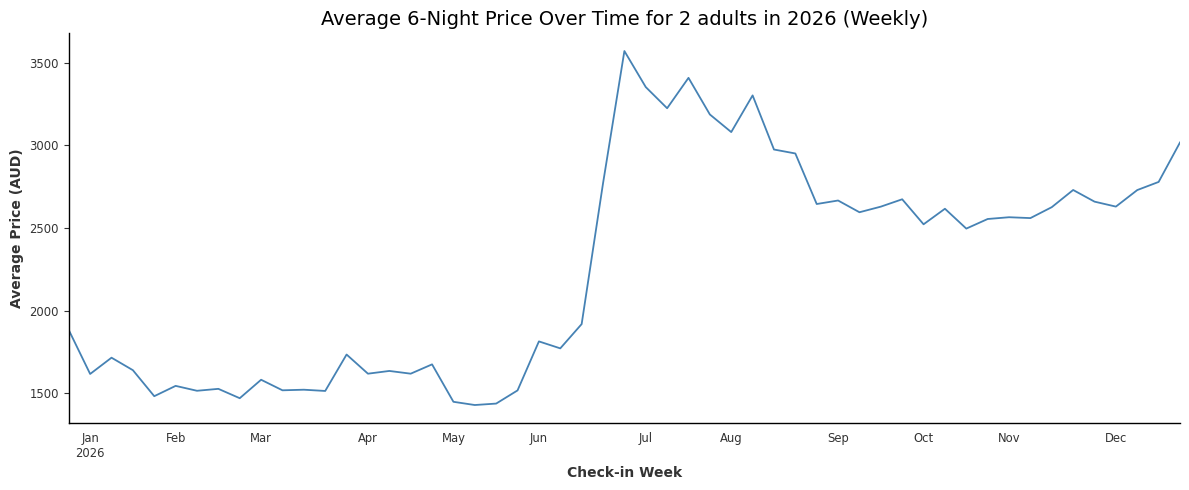

In [ ]:
# Ensure checkin is datetime
hotel_price_df["checkin"] = pd.to_datetime(hotel_price_df["checkin"], errors="coerce")

# --- 1. Overall weekly average ---
weekly_avg = hotel_price_df.groupby(hotel_price_df["checkin"].dt.to_period("W"))["price_total"].mean()
weekly_avg.index = weekly_avg.index.to_timestamp()

plt.figure(figsize=(12,5))
weekly_avg.plot(color="steelblue")
plt.title("Average 6-Night Price Over Time for 2 adults in 2026 (Weekly)", fontsize=14)
plt.xlabel("Check-in Week")
plt.ylabel("Average Price (AUD)")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.grid(False)
plt.show()

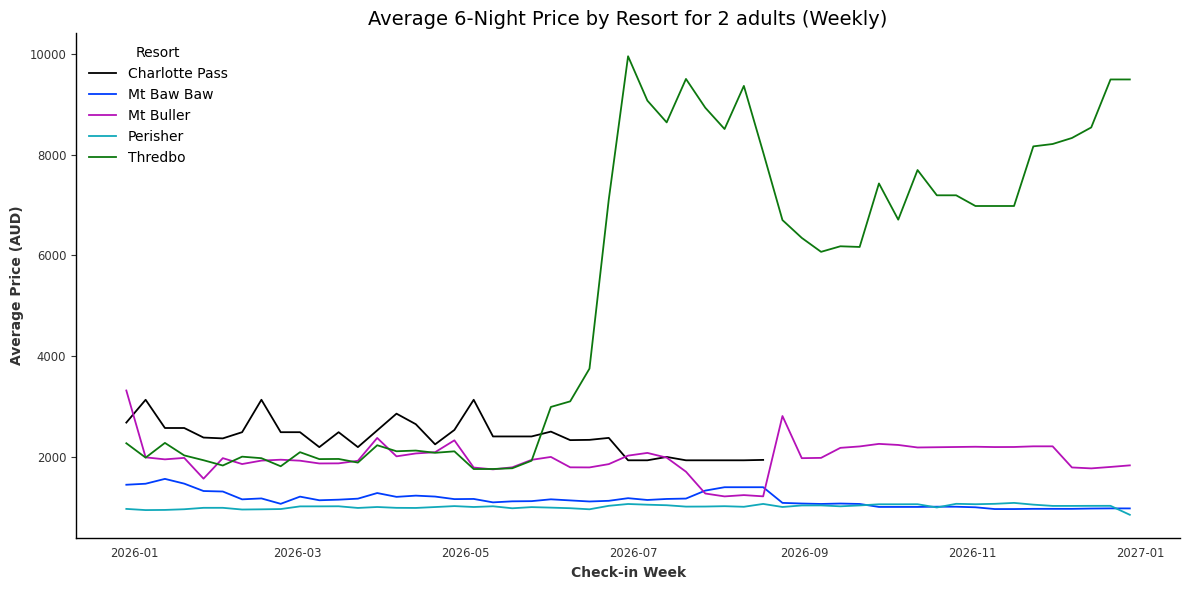

In [34]:
# --- Weekly average by resort ---
weekly_resort = hotel_price_df.groupby(
    [hotel_price_df["checkin"].dt.to_period("W"), "place"]
)["price_total"].mean().reset_index()

# Convert Period to Timestamp
weekly_resort["checkin"] = weekly_resort["checkin"].dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(data=weekly_resort, x="checkin", y="price_total", hue="place")
plt.title("Average 6-Night Price by Resort for 2 adults (Weekly)", fontsize=14)
plt.xlabel("Check-in Week")
plt.ylabel("Average Price (AUD)")
sns.despine(top=True, right=True)
plt.legend(title="Resort")
plt.tight_layout()
plt.grid(False)
plt.show()

# Scoring

## Import forecasted results

In [67]:
weekly_max_temp = pd.read_csv("weekly_max_temp_forecast.csv")
weekly_max_temp['week'] = pd.to_datetime(weekly_max_temp['week'])
weekly_max_temp_forecast = weekly_max_temp[weekly_max_temp['week'] > "2026-6-1"]
weekly_max_temp_forecast["week"] = weekly_max_temp_forecast["week"] + pd.Timedelta(days=1)
weekly_max_temp_forecast

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_9821/3862334233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_max_temp_forecast["week"] = weekly_max_temp_forecast["week"] + pd.Timedelta(days=1)


week  max_temp_forecast  ci_lower   ci_upper
43 2026-06-08           4.683489 -0.681416  10.048395
44 2026-06-15           3.373339 -1.996817   8.743495
45 2026-06-22           3.488434 -1.886968   8.863835
46 2026-06-29           3.075847 -2.304795   8.456490
47 2026-07-06           3.195070 -2.190808   8.580947
48 2026-07-13           3.135606 -2.255502   8.526713
49 2026-07-20           2.776085 -2.620248   8.172418
50 2026-07-27           3.409744 -1.991809   8.811297
51 2026-08-03           3.259477 -2.147291   8.666245
52 2026-08-10           4.104623 -1.356561   9.565807
53 2026-08-17           4.593375 -0.877844  10.064594
54 2026-08-24           5.446262 -0.032186  10.924710
55 2026-08-31           6.444167  0.959251  11.929084
56 2026-09-07           7.282345  1.791112  12.773578
57 2026-09-14           8.146189  2.648680  13.643698
58 2026-09-21           8.142407  2.638636  13.646177
59 2026-09-28          10.944435  5.434411  16.454459

In [68]:
score_df = pd.DataFrame()
score_df["week"] = weekly_max_temp_forecast["week"]
score_df["temp_score"] = 1 - weekly_max_temp_forecast["max_temp_forecast"].rank(pct=True)
score_df

week  temp_score
43 2026-06-08    0.352941
44 2026-06-15    0.647059
45 2026-06-22    0.529412
46 2026-06-29    0.882353
47 2026-07-06    0.764706
48 2026-07-13    0.823529
49 2026-07-20    0.941176
50 2026-07-27    0.588235
51 2026-08-03    0.705882
52 2026-08-10    0.470588
53 2026-08-17    0.411765
54 2026-08-24    0.294118
55 2026-08-31    0.235294
56 2026-09-07    0.176471
57 2026-09-14    0.058824
58 2026-09-21    0.117647
59 2026-09-28    0.000000

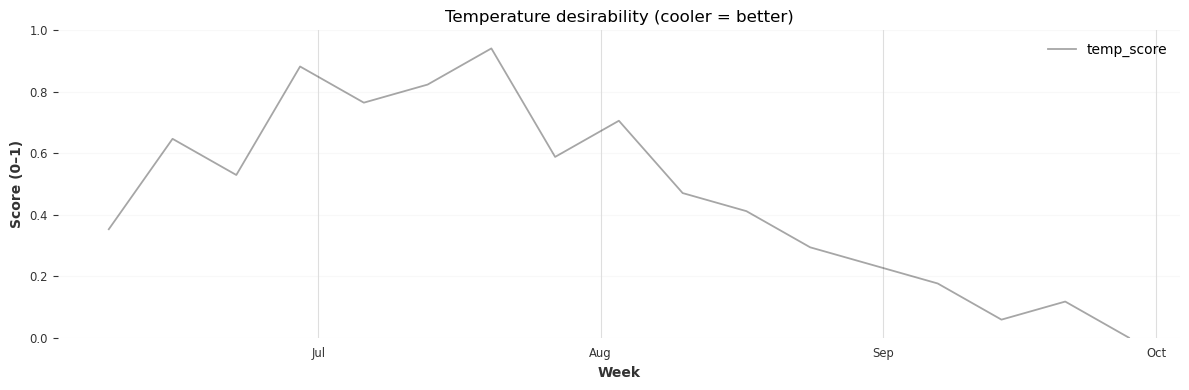

In [69]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# ensure sorted + datetime
score_df = score_df.copy()
score_df["week"] = pd.to_datetime(score_df["week"], errors="coerce")
score_df = score_df.sort_values("week")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(score_df["week"], score_df["temp_score"], alpha=0.35, label="temp_score")


ax.set_title("Temperature desirability (cooler = better)")
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Week")
ax.set_ylim(0, 1)

# Month labels only (no year under Jan)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

ax.grid(axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

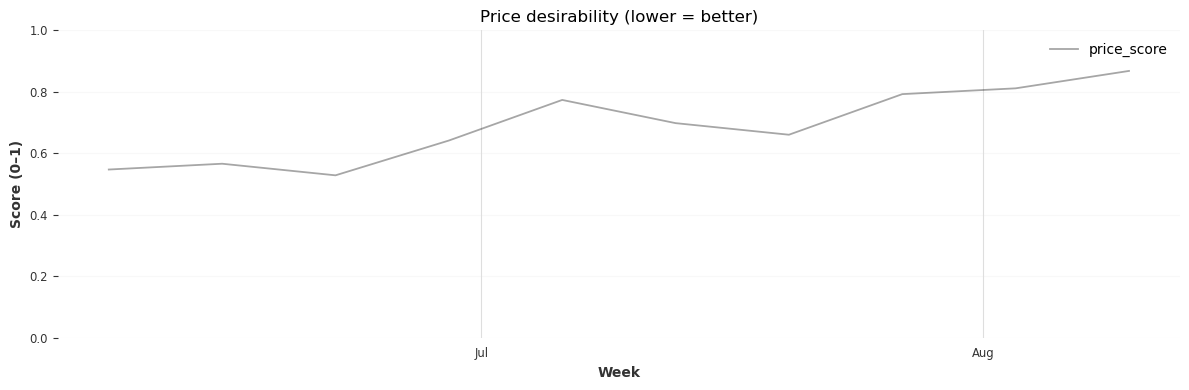

In [73]:
average_price_weekly = pd.read_csv("weekly_avg_price.csv")
score_df["price_score"] = average_price_weekly["avg_price"].rank(pct=True)

# ensure sorted + datetime
score_df = score_df.copy()
score_df["week"] = pd.to_datetime(score_df["week"], errors="coerce")
score_df = score_df.sort_values("week")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(score_df["week"], score_df["price_score"], alpha=0.35, label="price_score")


ax.set_title("Price desirability (lower = better)")
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Week")
ax.set_ylim(0, 1)

# Month labels only (no year under Jan)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

ax.grid(axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()


In [71]:
forecast_arima_visitors = pd.read_csv("forecast_arima_model7.csv")
forecast_arima_visitors

Date      Forecast
0   2001-10-01   9313.316092
1   2001-10-08  17456.030588
2   2001-10-15  42075.934328
3   2001-10-22  65996.788173
4   2001-10-29  81318.422336
5   2001-11-05  60787.650809
6   2001-11-12  61016.863510
7   2001-11-19  65905.674046
8   2001-11-26  71364.552344
9   2001-12-03  74201.086870
10  2001-12-10  70731.218358
11  2001-12-17  57145.757058
12  2001-12-24  48425.841527
13  2001-12-31  34070.889892
14  2002-01-07  20762.481810

In [89]:
# Step 1: Get number of weeks in score_df
n_weeks = len(score_df)

# Step 2: Trim forecast to match length
forecast_trimmed = forecast_arima_visitors.tail(n_weeks).copy().reset_index(drop=True)

# Step 3: Align forecast weeks with score_df weeks
forecast_trimmed["week"] = score_df["week"].reset_index(drop=True)

# Step 4: Rank visitor forecasts (lower = better)
forecast_trimmed["visitor_score"] = forecast_trimmed["Forecast"].rank(pct=True, ascending=True)

# Step 5: Clean up for merge
forecast_trimmed = forecast_trimmed[["week", "visitor_score"]]

# Step 6: Standardise datetime format (normalize to 00:00:00)
score_df["week"] = pd.to_datetime(score_df["week"]).dt.normalize()
forecast_trimmed["week"] = pd.to_datetime(forecast_trimmed["week"]).dt.normalize()

# Step 7: Drop old visitor_score if it exists (avoid conflict)
if "visitor_score" in score_df.columns:
    score_df = score_df.drop(columns=["visitor_score"])

# Step 8: Merge in visitor_score
score_df = score_df.merge(
    forecast_trimmed,
    on="week",
    how="left"
)
score_df

week  temp_score  price_score  visitor_score_x  visitor_score_y  \
0  2026-06-08    0.352941     0.547170              NaN         0.066667   
1  2026-06-15    0.647059     0.566038              NaN         0.133333   
2  2026-06-22    0.529412     0.528302              NaN         0.333333   
3  2026-06-29    0.882353     0.641509              NaN         0.733333   
4  2026-07-06    0.764706     0.773585              NaN         1.000000   
5  2026-07-13    0.823529     0.698113              NaN         0.533333   
6  2026-07-20    0.941176     0.660377              NaN         0.600000   
7  2026-07-27    0.588235     0.792453              NaN         0.666667   
8  2026-08-03    0.705882     0.811321              NaN         0.866667   
9  2026-08-10    0.470588     0.867925              NaN         0.933333   
10 2026-08-17    0.411765          NaN              NaN         0.800000   
11 2026-08-24    0.294118          NaN              NaN         0.466667   
12 2026-08-31    0.235294          NaN              NaN         0.400000   
13 2026-09-07    0.176471          NaN              NaN         0.266667   
14 2026-09-14    0.058824          NaN              NaN         0.200000   
15 2026-09-21    0.117647          NaN              NaN              NaN   
16 2026-09-28    0.000000          NaN              NaN              NaN   

    visitor_score  
0        0.066667  
1        0.133333  
2        0.333333  
3        0.733333  
4        1.000000  
5        0.533333  
6        0.600000  
7        0.666667  
8        0.866667  
9        0.933333  
10       0.800000  
11       0.466667  
12       0.400000  
13       0.266667  
14       0.200000  
15            NaN  
16            NaN

## Score Calculation

In [96]:
# Define weights (must sum to 1)
w_temp = 0.2
w_price = 0.5
w_visitor = 0.3

# Compute overall score
score_df["overall_score"] = (
    w_temp    * score_df["temp_score"] +
    w_price   * score_df["price_score"] +
    w_visitor * score_df["visitor_score"]
)

To convert forecasted maximum temperatures into a **desirability score** for skiing (where cooler weeks are preferred, less crowded and low price), we apply **percentile ranking** and invert it.

The formula is:

$$
\text{temp\_score}_i = 1 - \frac{\text{rank}(\text{max\_temp}_i)}{n}
$$

$$
\text{overall\_score}_i = w_{\text{temp}} \cdot \text{temp\_score}_i + w_{\text{price}} \cdot \text{price\_score}_i + w_{\text{visitor}} \cdot \text{visitor\_score}_i
$$

with weights of 0.5 for price, 0.3 for visitors and 0.2 for temperature

Best week start date: 2026-07-06 (score=0.840)


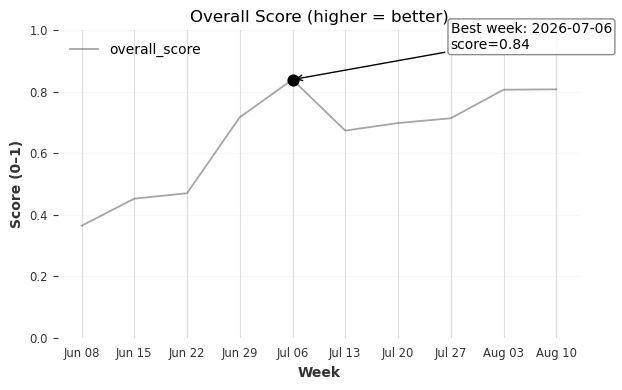

In [98]:
# ensure sorted + datetime
score_df = score_df.copy()
score_df["week"] = pd.to_datetime(score_df["week"], errors="coerce")
score_df = score_df.sort_values("week")

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(score_df["week"], score_df["overall_score"], alpha=0.35, label="overall_score")

ax.set_title("Overall Score (higher = better)")
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Week")
ax.set_ylim(0, 1)

# Month labels only (no year under Jan)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

ax.grid(axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()


# find best week (start date) by overall_score
valid = score_df.dropna(subset=["overall_score", "week"])
best_idx = valid["overall_score"].idxmax()
best_week = pd.to_datetime(valid.loc[best_idx, "week"])
best_score = float(valid.loc[best_idx, "overall_score"])

# mark + annotate on the chart
ax.scatter([best_week], [best_score], s=60, zorder=3)
ax.annotate(
    f"Best week: {best_week:%Y-%m-%d}\nscore={best_score:.2f}",
    xy=(best_week, best_score),
    xytext=(best_week + pd.Timedelta(days=21), min(0.95, best_score + 0.1)),
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.9)
)
# Add weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


print(f"Best week start date: {best_week:%Y-%m-%d} (score={best_score:.3f})")

plt.show()
